In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_2048_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 2048)              1703936   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4492168 (17.14 MB)


Trainable params: 4492168 (17.14 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:40 - loss: 3.0193 - STD: 0.1819 - MAE: 0.2349

 2/78 [..............................] - ETA: 1:08 - loss: 2.4734 - STD: 0.1488 - MAE: 0.2292

 4/78 [>.............................] - ETA: 23s - loss: 2.0341 - STD: 0.1197 - MAE: 0.2132 

 6/78 [=>............................] - ETA: 14s - loss: 1.8154 - STD: 0.1323 - MAE: 0.1957

 8/78 [==>...........................] - ETA: 10s - loss: 1.7004 - STD: 0.1519 - MAE: 0.1817

10/78 [==>...........................] - ETA: 8s - loss: 1.6272 - STD: 0.1670 - MAE: 0.1718 

12/78 [===>..........................] - ETA: 7s - loss: 1.5753 - STD: 0.1764 - MAE: 0.1654

14/78 [====>.........................] - ETA: 6s - loss: 1.5380 - STD: 0.1811 - MAE: 0.1616

16/78 [=====>........................] - ETA: 5s - loss: 1.5088 - STD: 0.1825 - MAE: 0.1595

18/78 [=====>........................] - ETA: 4s - loss: 1.4885 - STD: 0.1823 - MAE: 0.1584

20/78 [======>.......................] - ETA: 4s - loss: 1.4726 - STD: 0.1819 - MAE: 0.1577

22/78 [=======>......................] - ETA: 4s - loss: 1.4601 - STD: 0.1821 - MAE: 0.1569

24/78 [========>.....................] - ETA: 3s - loss: 1.4484 - STD: 0.1829 - MAE: 0.1559

26/78 [=========>....................] - ETA: 3s - loss: 1.4402 - STD: 0.1842 - MAE: 0.1550

28/78 [=========>....................] - ETA: 3s - loss: 1.4314 - STD: 0.1857 - MAE: 0.1539

30/78 [==========>...................] - ETA: 2s - loss: 1.4242 - STD: 0.1870 - MAE: 0.1530

32/78 [===========>..................] - ETA: 2s - loss: 1.4171 - STD: 0.1880 - MAE: 0.1522

34/78 [============>.................] - ETA: 2s - loss: 1.4119 - STD: 0.1886 - MAE: 0.1517

36/78 [============>.................] - ETA: 2s - loss: 1.4064 - STD: 0.1889 - MAE: 0.1513

38/78 [=============>................] - ETA: 2s - loss: 1.4019 - STD: 0.1889 - MAE: 0.1510

40/78 [==============>...............] - ETA: 1s - loss: 1.3981 - STD: 0.1889 - MAE: 0.1508

42/78 [===============>..............] - ETA: 1s - loss: 1.3944 - STD: 0.1889 - MAE: 0.1506

44/78 [===============>..............] - ETA: 1s - loss: 1.3915 - STD: 0.1889 - MAE: 0.1504

46/78 [================>.............] - ETA: 1s - loss: 1.3883 - STD: 0.1891 - MAE: 0.1502

48/78 [=================>............] - ETA: 1s - loss: 1.3850 - STD: 0.1893 - MAE: 0.1499

50/78 [==================>...........] - ETA: 1s - loss: 1.3823 - STD: 0.1895 - MAE: 0.1497

52/78 [===================>..........] - ETA: 1s - loss: 1.3801 - STD: 0.1898 - MAE: 0.1494

54/78 [===================>..........] - ETA: 1s - loss: 1.3771 - STD: 0.1900 - MAE: 0.1492

56/78 [====================>.........] - ETA: 1s - loss: 1.3747 - STD: 0.1901 - MAE: 0.1490

58/78 [=====================>........] - ETA: 0s - loss: 1.3729 - STD: 0.1902 - MAE: 0.1489

60/78 [======================>.......] - ETA: 0s - loss: 1.3711 - STD: 0.1903 - MAE: 0.1488

62/78 [======================>.......] - ETA: 0s - loss: 1.3696 - STD: 0.1904 - MAE: 0.1487

64/78 [=======================>......] - ETA: 0s - loss: 1.3680 - STD: 0.1904 - MAE: 0.1486

66/78 [========================>.....] - ETA: 0s - loss: 1.3669 - STD: 0.1905 - MAE: 0.1485

68/78 [=========================>....] - ETA: 0s - loss: 1.3650 - STD: 0.1905 - MAE: 0.1484

70/78 [=========================>....] - ETA: 0s - loss: 1.3635 - STD: 0.1906 - MAE: 0.1482

72/78 [==========================>...] - ETA: 0s - loss: 1.3620 - STD: 0.1907 - MAE: 0.1481

74/78 [===========================>..] - ETA: 0s - loss: 1.3607 - STD: 0.1908 - MAE: 0.1480

76/78 [============================>.] - ETA: 0s - loss: 1.3596 - STD: 0.1908 - MAE: 0.1480

78/78 [==============================] - ETA: 0s - loss: 1.3585 - STD: 0.1908 - MAE: 0.1479

78/78 [==============================] - 5s 52ms/step - loss: 1.3585 - STD: 0.1908 - MAE: 0.1479 - val_loss: 1.2741 - val_STD: 0.1911 - val_MAE: 0.1452


Epoch 2/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3239 - STD: 0.1911 - MAE: 0.1457

 3/78 [>.............................] - ETA: 2s - loss: 1.3181 - STD: 0.1909 - MAE: 0.1456

 5/78 [>.............................] - ETA: 2s - loss: 1.3163 - STD: 0.1909 - MAE: 0.1456

 7/78 [=>............................] - ETA: 2s - loss: 1.3175 - STD: 0.1911 - MAE: 0.1456

 9/78 [==>...........................] - ETA: 2s - loss: 1.3148 - STD: 0.1913 - MAE: 0.1453

11/78 [===>..........................] - ETA: 2s - loss: 1.3143 - STD: 0.1916 - MAE: 0.1452

13/78 [====>.........................] - ETA: 1s - loss: 1.3140 - STD: 0.1918 - MAE: 0.1452

15/78 [====>.........................] - ETA: 1s - loss: 1.3146 - STD: 0.1918 - MAE: 0.1451

17/78 [=====>........................] - ETA: 1s - loss: 1.3142 - STD: 0.1918 - MAE: 0.1452

19/78 [======>.......................] - ETA: 1s - loss: 1.3152 - STD: 0.1917 - MAE: 0.1452

21/78 [=======>......................] - ETA: 1s - loss: 1.3158 - STD: 0.1917 - MAE: 0.1453

23/78 [=======>......................] - ETA: 1s - loss: 1.3151 - STD: 0.1917 - MAE: 0.1452

25/78 [========>.....................] - ETA: 1s - loss: 1.3151 - STD: 0.1917 - MAE: 0.1452

27/78 [=========>....................] - ETA: 1s - loss: 1.3144 - STD: 0.1917 - MAE: 0.1452

29/78 [==========>...................] - ETA: 1s - loss: 1.3148 - STD: 0.1917 - MAE: 0.1452

31/78 [==========>...................] - ETA: 1s - loss: 1.3154 - STD: 0.1917 - MAE: 0.1453

33/78 [===========>..................] - ETA: 1s - loss: 1.3162 - STD: 0.1916 - MAE: 0.1453

35/78 [============>.................] - ETA: 1s - loss: 1.3168 - STD: 0.1915 - MAE: 0.1454

37/78 [=============>................] - ETA: 1s - loss: 1.3173 - STD: 0.1913 - MAE: 0.1455

39/78 [==============>...............] - ETA: 1s - loss: 1.3175 - STD: 0.1912 - MAE: 0.1456

41/78 [==============>...............] - ETA: 1s - loss: 1.3172 - STD: 0.1912 - MAE: 0.1455

43/78 [===============>..............] - ETA: 1s - loss: 1.3172 - STD: 0.1912 - MAE: 0.1455

45/78 [================>.............] - ETA: 1s - loss: 1.3172 - STD: 0.1914 - MAE: 0.1455

47/78 [=================>............] - ETA: 0s - loss: 1.3167 - STD: 0.1915 - MAE: 0.1454

49/78 [=================>............] - ETA: 0s - loss: 1.3169 - STD: 0.1915 - MAE: 0.1454

51/78 [==================>...........] - ETA: 0s - loss: 1.3168 - STD: 0.1915 - MAE: 0.1454

53/78 [===================>..........] - ETA: 0s - loss: 1.3165 - STD: 0.1914 - MAE: 0.1454

55/78 [====================>.........] - ETA: 0s - loss: 1.3167 - STD: 0.1913 - MAE: 0.1455

57/78 [====================>.........] - ETA: 0s - loss: 1.3166 - STD: 0.1913 - MAE: 0.1455

59/78 [=====================>........] - ETA: 0s - loss: 1.3170 - STD: 0.1913 - MAE: 0.1455

61/78 [======================>.......] - ETA: 0s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1455

63/78 [=======================>......] - ETA: 0s - loss: 1.3166 - STD: 0.1914 - MAE: 0.1454

65/78 [========================>.....] - ETA: 0s - loss: 1.3165 - STD: 0.1914 - MAE: 0.1454

67/78 [========================>.....] - ETA: 0s - loss: 1.3162 - STD: 0.1915 - MAE: 0.1454

69/78 [=========================>....] - ETA: 0s - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454

71/78 [==========================>...] - ETA: 0s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1454

74/78 [===========================>..] - ETA: 0s - loss: 1.3162 - STD: 0.1914 - MAE: 0.1454

76/78 [============================>.] - ETA: 0s - loss: 1.3163 - STD: 0.1915 - MAE: 0.1454

78/78 [==============================] - ETA: 0s - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454

78/78 [==============================] - 3s 33ms/step - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454 - val_loss: 1.2745 - val_STD: 0.1905 - val_MAE: 0.1454


Epoch 3/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3138 - STD: 0.1905 - MAE: 0.1455

 3/78 [>.............................] - ETA: 2s - loss: 1.3130 - STD: 0.1901 - MAE: 0.1458

 5/78 [>.............................] - ETA: 2s - loss: 1.3139 - STD: 0.1900 - MAE: 0.1459

 7/78 [=>............................] - ETA: 2s - loss: 1.3131 - STD: 0.1903 - MAE: 0.1458

 9/78 [==>...........................] - ETA: 2s - loss: 1.3115 - STD: 0.1907 - MAE: 0.1455

11/78 [===>..........................] - ETA: 2s - loss: 1.3131 - STD: 0.1912 - MAE: 0.1454

13/78 [====>.........................] - ETA: 1s - loss: 1.3134 - STD: 0.1916 - MAE: 0.1452

15/78 [====>.........................] - ETA: 1s - loss: 1.3132 - STD: 0.1917 - MAE: 0.1452

17/78 [=====>........................] - ETA: 1s - loss: 1.3152 - STD: 0.1917 - MAE: 0.1453

19/78 [======>.......................] - ETA: 1s - loss: 1.3157 - STD: 0.1915 - MAE: 0.1454

21/78 [=======>......................] - ETA: 1s - loss: 1.3149 - STD: 0.1913 - MAE: 0.1454

23/78 [=======>......................] - ETA: 1s - loss: 1.3150 - STD: 0.1913 - MAE: 0.1454

25/78 [========>.....................] - ETA: 1s - loss: 1.3153 - STD: 0.1914 - MAE: 0.1454

27/78 [=========>....................] - ETA: 1s - loss: 1.3160 - STD: 0.1914 - MAE: 0.1455

29/78 [==========>...................] - ETA: 1s - loss: 1.3162 - STD: 0.1913 - MAE: 0.1455

31/78 [==========>...................] - ETA: 1s - loss: 1.3162 - STD: 0.1912 - MAE: 0.1456

33/78 [===========>..................] - ETA: 1s - loss: 1.3167 - STD: 0.1912 - MAE: 0.1456

35/78 [============>.................] - ETA: 1s - loss: 1.3171 - STD: 0.1912 - MAE: 0.1456

37/78 [=============>................] - ETA: 1s - loss: 1.3166 - STD: 0.1912 - MAE: 0.1455

39/78 [==============>...............] - ETA: 1s - loss: 1.3164 - STD: 0.1913 - MAE: 0.1455

41/78 [==============>...............] - ETA: 1s - loss: 1.3166 - STD: 0.1914 - MAE: 0.1455

43/78 [===============>..............] - ETA: 1s - loss: 1.3166 - STD: 0.1914 - MAE: 0.1455

46/78 [================>.............] - ETA: 0s - loss: 1.3168 - STD: 0.1913 - MAE: 0.1456

48/78 [=================>............] - ETA: 0s - loss: 1.3167 - STD: 0.1911 - MAE: 0.1456

50/78 [==================>...........] - ETA: 0s - loss: 1.3162 - STD: 0.1911 - MAE: 0.1456

52/78 [===================>..........] - ETA: 0s - loss: 1.3161 - STD: 0.1913 - MAE: 0.1455

54/78 [===================>..........] - ETA: 0s - loss: 1.3158 - STD: 0.1915 - MAE: 0.1454

56/78 [====================>.........] - ETA: 0s - loss: 1.3154 - STD: 0.1916 - MAE: 0.1454

58/78 [=====================>........] - ETA: 0s - loss: 1.3152 - STD: 0.1916 - MAE: 0.1453

60/78 [======================>.......] - ETA: 0s - loss: 1.3154 - STD: 0.1916 - MAE: 0.1454

62/78 [======================>.......] - ETA: 0s - loss: 1.3155 - STD: 0.1915 - MAE: 0.1454

64/78 [=======================>......] - ETA: 0s - loss: 1.3156 - STD: 0.1914 - MAE: 0.1454

66/78 [========================>.....] - ETA: 0s - loss: 1.3164 - STD: 0.1914 - MAE: 0.1455

68/78 [=========================>....] - ETA: 0s - loss: 1.3165 - STD: 0.1914 - MAE: 0.1455

70/78 [=========================>....] - ETA: 0s - loss: 1.3161 - STD: 0.1914 - MAE: 0.1455

72/78 [==========================>...] - ETA: 0s - loss: 1.3159 - STD: 0.1914 - MAE: 0.1455

74/78 [===========================>..] - ETA: 0s - loss: 1.3162 - STD: 0.1914 - MAE: 0.1455

76/78 [============================>.] - ETA: 0s - loss: 1.3165 - STD: 0.1914 - MAE: 0.1455

78/78 [==============================] - ETA: 0s - loss: 1.3165 - STD: 0.1914 - MAE: 0.1455

78/78 [==============================] - 3s 33ms/step - loss: 1.3165 - STD: 0.1914 - MAE: 0.1455 - val_loss: 1.2745 - val_STD: 0.1899 - val_MAE: 0.1456


Epoch 4/10000


 1/78 [..............................] - ETA: 5s - loss: 1.3119 - STD: 0.1899 - MAE: 0.1457

 3/78 [>.............................] - ETA: 2s - loss: 1.3270 - STD: 0.1908 - MAE: 0.1463

 5/78 [>.............................] - ETA: 2s - loss: 1.3220 - STD: 0.1910 - MAE: 0.1459

 7/78 [=>............................] - ETA: 2s - loss: 1.3203 - STD: 0.1911 - MAE: 0.1458

 9/78 [==>...........................] - ETA: 2s - loss: 1.3191 - STD: 0.1911 - MAE: 0.1457

11/78 [===>..........................] - ETA: 2s - loss: 1.3158 - STD: 0.1910 - MAE: 0.1456

13/78 [====>.........................] - ETA: 1s - loss: 1.3185 - STD: 0.1912 - MAE: 0.1457

15/78 [====>.........................] - ETA: 1s - loss: 1.3196 - STD: 0.1913 - MAE: 0.1457

17/78 [=====>........................] - ETA: 1s - loss: 1.3169 - STD: 0.1913 - MAE: 0.1455

19/78 [======>.......................] - ETA: 1s - loss: 1.3179 - STD: 0.1914 - MAE: 0.1455

21/78 [=======>......................] - ETA: 1s - loss: 1.3177 - STD: 0.1914 - MAE: 0.1455

23/78 [=======>......................] - ETA: 1s - loss: 1.3178 - STD: 0.1914 - MAE: 0.1455

25/78 [========>.....................] - ETA: 1s - loss: 1.3179 - STD: 0.1914 - MAE: 0.1455

27/78 [=========>....................] - ETA: 1s - loss: 1.3176 - STD: 0.1914 - MAE: 0.1455

29/78 [==========>...................] - ETA: 1s - loss: 1.3174 - STD: 0.1914 - MAE: 0.1455

31/78 [==========>...................] - ETA: 1s - loss: 1.3178 - STD: 0.1914 - MAE: 0.1455

33/78 [===========>..................] - ETA: 1s - loss: 1.3177 - STD: 0.1913 - MAE: 0.1455

35/78 [============>.................] - ETA: 1s - loss: 1.3174 - STD: 0.1913 - MAE: 0.1456

37/78 [=============>................] - ETA: 1s - loss: 1.3167 - STD: 0.1912 - MAE: 0.1455

39/78 [==============>...............] - ETA: 1s - loss: 1.3166 - STD: 0.1913 - MAE: 0.1455

41/78 [==============>...............] - ETA: 1s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1454

43/78 [===============>..............] - ETA: 1s - loss: 1.3166 - STD: 0.1915 - MAE: 0.1454

45/78 [================>.............] - ETA: 1s - loss: 1.3168 - STD: 0.1915 - MAE: 0.1454

47/78 [=================>............] - ETA: 0s - loss: 1.3164 - STD: 0.1914 - MAE: 0.1455

49/78 [=================>............] - ETA: 0s - loss: 1.3159 - STD: 0.1914 - MAE: 0.1455

51/78 [==================>...........] - ETA: 0s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1454

53/78 [===================>..........] - ETA: 0s - loss: 1.3166 - STD: 0.1915 - MAE: 0.1454

55/78 [====================>.........] - ETA: 0s - loss: 1.3164 - STD: 0.1916 - MAE: 0.1454

57/78 [====================>.........] - ETA: 0s - loss: 1.3167 - STD: 0.1915 - MAE: 0.1454

59/78 [=====================>........] - ETA: 0s - loss: 1.3166 - STD: 0.1914 - MAE: 0.1455

61/78 [======================>.......] - ETA: 0s - loss: 1.3167 - STD: 0.1914 - MAE: 0.1455

63/78 [=======================>......] - ETA: 0s - loss: 1.3167 - STD: 0.1914 - MAE: 0.1455

65/78 [========================>.....] - ETA: 0s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1455

67/78 [========================>.....] - ETA: 0s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1455

69/78 [=========================>....] - ETA: 0s - loss: 1.3168 - STD: 0.1914 - MAE: 0.1455

71/78 [==========================>...] - ETA: 0s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1455

74/78 [===========================>..] - ETA: 0s - loss: 1.3167 - STD: 0.1914 - MAE: 0.1455

76/78 [============================>.] - ETA: 0s - loss: 1.3166 - STD: 0.1914 - MAE: 0.1455

78/78 [==============================] - ETA: 0s - loss: 1.3165 - STD: 0.1915 - MAE: 0.1454

78/78 [==============================] - 3s 33ms/step - loss: 1.3165 - STD: 0.1915 - MAE: 0.1454 - val_loss: 1.2743 - val_STD: 0.1935 - val_MAE: 0.1443


Epoch 5/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3240 - STD: 0.1935 - MAE: 0.1453

 4/78 [>.............................] - ETA: 1s - loss: 1.3197 - STD: 0.1918 - MAE: 0.1453

 6/78 [=>............................] - ETA: 1s - loss: 1.3183 - STD: 0.1912 - MAE: 0.1455

 8/78 [==>...........................] - ETA: 1s - loss: 1.3187 - STD: 0.1910 - MAE: 0.1457

10/78 [==>...........................] - ETA: 1s - loss: 1.3176 - STD: 0.1909 - MAE: 0.1456

12/78 [===>..........................] - ETA: 1s - loss: 1.3190 - STD: 0.1910 - MAE: 0.1456

14/78 [====>.........................] - ETA: 1s - loss: 1.3178 - STD: 0.1913 - MAE: 0.1455

16/78 [=====>........................] - ETA: 1s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1454

18/78 [=====>........................] - ETA: 1s - loss: 1.3176 - STD: 0.1915 - MAE: 0.1455

20/78 [======>.......................] - ETA: 1s - loss: 1.3171 - STD: 0.1913 - MAE: 0.1455

22/78 [=======>......................] - ETA: 1s - loss: 1.3176 - STD: 0.1911 - MAE: 0.1456

24/78 [========>.....................] - ETA: 1s - loss: 1.3180 - STD: 0.1911 - MAE: 0.1457

26/78 [=========>....................] - ETA: 1s - loss: 1.3187 - STD: 0.1911 - MAE: 0.1457

28/78 [=========>....................] - ETA: 1s - loss: 1.3178 - STD: 0.1911 - MAE: 0.1456

30/78 [==========>...................] - ETA: 1s - loss: 1.3187 - STD: 0.1912 - MAE: 0.1456

32/78 [===========>..................] - ETA: 1s - loss: 1.3180 - STD: 0.1912 - MAE: 0.1456

34/78 [============>.................] - ETA: 1s - loss: 1.3176 - STD: 0.1912 - MAE: 0.1456

36/78 [============>.................] - ETA: 1s - loss: 1.3176 - STD: 0.1912 - MAE: 0.1456

38/78 [=============>................] - ETA: 1s - loss: 1.3170 - STD: 0.1913 - MAE: 0.1455

40/78 [==============>...............] - ETA: 1s - loss: 1.3173 - STD: 0.1913 - MAE: 0.1455

42/78 [===============>..............] - ETA: 1s - loss: 1.3176 - STD: 0.1913 - MAE: 0.1455

44/78 [===============>..............] - ETA: 1s - loss: 1.3178 - STD: 0.1913 - MAE: 0.1456

46/78 [================>.............] - ETA: 0s - loss: 1.3172 - STD: 0.1912 - MAE: 0.1456

48/78 [=================>............] - ETA: 0s - loss: 1.3169 - STD: 0.1913 - MAE: 0.1455

50/78 [==================>...........] - ETA: 0s - loss: 1.3167 - STD: 0.1914 - MAE: 0.1454

52/78 [===================>..........] - ETA: 0s - loss: 1.3166 - STD: 0.1915 - MAE: 0.1454

54/78 [===================>..........] - ETA: 0s - loss: 1.3165 - STD: 0.1914 - MAE: 0.1455

56/78 [====================>.........] - ETA: 0s - loss: 1.3166 - STD: 0.1913 - MAE: 0.1455

58/78 [=====================>........] - ETA: 0s - loss: 1.3161 - STD: 0.1912 - MAE: 0.1455

60/78 [======================>.......] - ETA: 0s - loss: 1.3157 - STD: 0.1914 - MAE: 0.1454

62/78 [======================>.......] - ETA: 0s - loss: 1.3154 - STD: 0.1915 - MAE: 0.1453

64/78 [=======================>......] - ETA: 0s - loss: 1.3156 - STD: 0.1916 - MAE: 0.1453

66/78 [========================>.....] - ETA: 0s - loss: 1.3150 - STD: 0.1915 - MAE: 0.1453

68/78 [=========================>....] - ETA: 0s - loss: 1.3152 - STD: 0.1915 - MAE: 0.1453

70/78 [=========================>....] - ETA: 0s - loss: 1.3152 - STD: 0.1915 - MAE: 0.1453

72/78 [==========================>...] - ETA: 0s - loss: 1.3153 - STD: 0.1915 - MAE: 0.1453

74/78 [===========================>..] - ETA: 0s - loss: 1.3152 - STD: 0.1915 - MAE: 0.1453

76/78 [============================>.] - ETA: 0s - loss: 1.3148 - STD: 0.1915 - MAE: 0.1453

78/78 [==============================] - ETA: 0s - loss: 1.3150 - STD: 0.1914 - MAE: 0.1453

78/78 [==============================] - 3s 33ms/step - loss: 1.3150 - STD: 0.1914 - MAE: 0.1453 - val_loss: 1.2616 - val_STD: 0.1926 - val_MAE: 0.1437


Epoch 6/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3159 - STD: 0.1930 - MAE: 0.1446

 3/78 [>.............................] - ETA: 2s - loss: 1.3002 - STD: 0.1921 - MAE: 0.1441

 5/78 [>.............................] - ETA: 2s - loss: 1.3037 - STD: 0.1906 - MAE: 0.1449

 7/78 [=>............................] - ETA: 2s - loss: 1.3046 - STD: 0.1908 - MAE: 0.1448

 9/78 [==>...........................] - ETA: 2s - loss: 1.3032 - STD: 0.1905 - MAE: 0.1448

11/78 [===>..........................] - ETA: 2s - loss: 1.3022 - STD: 0.1904 - MAE: 0.1448

13/78 [====>.........................] - ETA: 1s - loss: 1.2986 - STD: 0.1913 - MAE: 0.1442

15/78 [====>.........................] - ETA: 1s - loss: 1.2979 - STD: 0.1915 - MAE: 0.1441

17/78 [=====>........................] - ETA: 1s - loss: 1.2953 - STD: 0.1919 - MAE: 0.1438

19/78 [======>.......................] - ETA: 1s - loss: 1.2953 - STD: 0.1914 - MAE: 0.1439

21/78 [=======>......................] - ETA: 1s - loss: 1.2953 - STD: 0.1920 - MAE: 0.1437

23/78 [=======>......................] - ETA: 1s - loss: 1.2929 - STD: 0.1922 - MAE: 0.1435

25/78 [========>.....................] - ETA: 1s - loss: 1.2911 - STD: 0.1922 - MAE: 0.1434

27/78 [=========>....................] - ETA: 1s - loss: 1.2896 - STD: 0.1923 - MAE: 0.1433

29/78 [==========>...................] - ETA: 1s - loss: 1.2882 - STD: 0.1927 - MAE: 0.1430

31/78 [==========>...................] - ETA: 1s - loss: 1.2871 - STD: 0.1926 - MAE: 0.1430

33/78 [===========>..................] - ETA: 1s - loss: 1.2863 - STD: 0.1931 - MAE: 0.1428

35/78 [============>.................] - ETA: 1s - loss: 1.2851 - STD: 0.1931 - MAE: 0.1427

37/78 [=============>................] - ETA: 1s - loss: 1.2838 - STD: 0.1935 - MAE: 0.1425

39/78 [==============>...............] - ETA: 1s - loss: 1.2831 - STD: 0.1936 - MAE: 0.1424

41/78 [==============>...............] - ETA: 1s - loss: 1.2820 - STD: 0.1939 - MAE: 0.1422

43/78 [===============>..............] - ETA: 1s - loss: 1.2798 - STD: 0.1943 - MAE: 0.1419

45/78 [================>.............] - ETA: 1s - loss: 1.2781 - STD: 0.1943 - MAE: 0.1418

47/78 [=================>............] - ETA: 0s - loss: 1.2768 - STD: 0.1948 - MAE: 0.1416

49/78 [=================>............] - ETA: 0s - loss: 1.2762 - STD: 0.1945 - MAE: 0.1417

51/78 [==================>...........] - ETA: 0s - loss: 1.2744 - STD: 0.1950 - MAE: 0.1414

53/78 [===================>..........] - ETA: 0s - loss: 1.2731 - STD: 0.1951 - MAE: 0.1413

55/78 [====================>.........] - ETA: 0s - loss: 1.2721 - STD: 0.1951 - MAE: 0.1412

57/78 [====================>.........] - ETA: 0s - loss: 1.2712 - STD: 0.1955 - MAE: 0.1410

59/78 [=====================>........] - ETA: 0s - loss: 1.2701 - STD: 0.1957 - MAE: 0.1409

61/78 [======================>.......] - ETA: 0s - loss: 1.2690 - STD: 0.1954 - MAE: 0.1410

63/78 [=======================>......] - ETA: 0s - loss: 1.2680 - STD: 0.1959 - MAE: 0.1408

65/78 [========================>.....] - ETA: 0s - loss: 1.2667 - STD: 0.1959 - MAE: 0.1407

67/78 [========================>.....] - ETA: 0s - loss: 1.2653 - STD: 0.1960 - MAE: 0.1406

69/78 [=========================>....] - ETA: 0s - loss: 1.2643 - STD: 0.1963 - MAE: 0.1405

71/78 [==========================>...] - ETA: 0s - loss: 1.2630 - STD: 0.1962 - MAE: 0.1405

73/78 [===========================>..] - ETA: 0s - loss: 1.2616 - STD: 0.1963 - MAE: 0.1403

75/78 [===========================>..] - ETA: 0s - loss: 1.2598 - STD: 0.1967 - MAE: 0.1401

78/78 [==============================] - ETA: 0s - loss: 1.2582 - STD: 0.1969 - MAE: 0.1400

78/78 [==============================] - 3s 33ms/step - loss: 1.2582 - STD: 0.1969 - MAE: 0.1400 - val_loss: 1.1743 - val_STD: 0.1866 - val_MAE: 0.1409


Epoch 7/10000


 1/78 [..............................] - ETA: 4s - loss: 1.1742 - STD: 0.1896 - MAE: 0.1394

 3/78 [>.............................] - ETA: 2s - loss: 1.1892 - STD: 0.2014 - MAE: 0.1356

 5/78 [>.............................] - ETA: 2s - loss: 1.1900 - STD: 0.2017 - MAE: 0.1357

 7/78 [=>............................] - ETA: 2s - loss: 1.1848 - STD: 0.2015 - MAE: 0.1357

 9/78 [==>...........................] - ETA: 2s - loss: 1.1852 - STD: 0.2023 - MAE: 0.1354

11/78 [===>..........................] - ETA: 2s - loss: 1.1836 - STD: 0.2023 - MAE: 0.1354

13/78 [====>.........................] - ETA: 1s - loss: 1.1822 - STD: 0.2017 - MAE: 0.1357

15/78 [====>.........................] - ETA: 1s - loss: 1.1815 - STD: 0.2015 - MAE: 0.1358

17/78 [=====>........................] - ETA: 1s - loss: 1.1793 - STD: 0.2012 - MAE: 0.1359

19/78 [======>.......................] - ETA: 1s - loss: 1.1773 - STD: 0.2018 - MAE: 0.1356

21/78 [=======>......................] - ETA: 1s - loss: 1.1749 - STD: 0.2029 - MAE: 0.1350

23/78 [=======>......................] - ETA: 1s - loss: 1.1743 - STD: 0.2019 - MAE: 0.1354

25/78 [========>.....................] - ETA: 1s - loss: 1.1724 - STD: 0.2026 - MAE: 0.1351

27/78 [=========>....................] - ETA: 1s - loss: 1.1717 - STD: 0.2027 - MAE: 0.1351

29/78 [==========>...................] - ETA: 1s - loss: 1.1709 - STD: 0.2025 - MAE: 0.1352

31/78 [==========>...................] - ETA: 1s - loss: 1.1696 - STD: 0.2020 - MAE: 0.1353

33/78 [===========>..................] - ETA: 1s - loss: 1.1682 - STD: 0.2025 - MAE: 0.1351

35/78 [============>.................] - ETA: 1s - loss: 1.1663 - STD: 0.2028 - MAE: 0.1350

37/78 [=============>................] - ETA: 1s - loss: 1.1640 - STD: 0.2024 - MAE: 0.1351

39/78 [==============>...............] - ETA: 1s - loss: 1.1622 - STD: 0.2028 - MAE: 0.1349

41/78 [==============>...............] - ETA: 1s - loss: 1.1599 - STD: 0.2025 - MAE: 0.1349

43/78 [===============>..............] - ETA: 1s - loss: 1.1586 - STD: 0.2028 - MAE: 0.1348

45/78 [================>.............] - ETA: 1s - loss: 1.1563 - STD: 0.2031 - MAE: 0.1346

47/78 [=================>............] - ETA: 0s - loss: 1.1541 - STD: 0.2030 - MAE: 0.1346

49/78 [=================>............] - ETA: 0s - loss: 1.1522 - STD: 0.2033 - MAE: 0.1344

51/78 [==================>...........] - ETA: 0s - loss: 1.1513 - STD: 0.2031 - MAE: 0.1344

54/78 [===================>..........] - ETA: 0s - loss: 1.1495 - STD: 0.2034 - MAE: 0.1342

56/78 [====================>.........] - ETA: 0s - loss: 1.1486 - STD: 0.2036 - MAE: 0.1341

58/78 [=====================>........] - ETA: 0s - loss: 1.1473 - STD: 0.2035 - MAE: 0.1341

60/78 [======================>.......] - ETA: 0s - loss: 1.1461 - STD: 0.2036 - MAE: 0.1341

62/78 [======================>.......] - ETA: 0s - loss: 1.1449 - STD: 0.2035 - MAE: 0.1341

64/78 [=======================>......] - ETA: 0s - loss: 1.1436 - STD: 0.2038 - MAE: 0.1340

66/78 [========================>.....] - ETA: 0s - loss: 1.1418 - STD: 0.2037 - MAE: 0.1339

68/78 [=========================>....] - ETA: 0s - loss: 1.1405 - STD: 0.2041 - MAE: 0.1337

70/78 [=========================>....] - ETA: 0s - loss: 1.1387 - STD: 0.2040 - MAE: 0.1337

72/78 [==========================>...] - ETA: 0s - loss: 1.1370 - STD: 0.2043 - MAE: 0.1336

74/78 [===========================>..] - ETA: 0s - loss: 1.1355 - STD: 0.2040 - MAE: 0.1336

76/78 [============================>.] - ETA: 0s - loss: 1.1341 - STD: 0.2043 - MAE: 0.1335

78/78 [==============================] - ETA: 0s - loss: 1.1326 - STD: 0.2043 - MAE: 0.1334

78/78 [==============================] - 3s 33ms/step - loss: 1.1326 - STD: 0.2043 - MAE: 0.1334 - val_loss: 1.0612 - val_STD: 0.2105 - val_MAE: 0.1279


Epoch 8/10000


 1/78 [..............................] - ETA: 4s - loss: 1.0588 - STD: 0.2148 - MAE: 0.1263

 3/78 [>.............................] - ETA: 2s - loss: 1.0668 - STD: 0.2087 - MAE: 0.1294

 5/78 [>.............................] - ETA: 2s - loss: 1.0657 - STD: 0.2095 - MAE: 0.1290

 7/78 [=>............................] - ETA: 2s - loss: 1.0621 - STD: 0.2101 - MAE: 0.1286

 9/78 [==>...........................] - ETA: 2s - loss: 1.0635 - STD: 0.2096 - MAE: 0.1289

11/78 [===>..........................] - ETA: 2s - loss: 1.0610 - STD: 0.2116 - MAE: 0.1279

13/78 [====>.........................] - ETA: 2s - loss: 1.0653 - STD: 0.2079 - MAE: 0.1297

15/78 [====>.........................] - ETA: 1s - loss: 1.0682 - STD: 0.2101 - MAE: 0.1288

17/78 [=====>........................] - ETA: 1s - loss: 1.0694 - STD: 0.2082 - MAE: 0.1298

19/78 [======>.......................] - ETA: 1s - loss: 1.0703 - STD: 0.2109 - MAE: 0.1287

21/78 [=======>......................] - ETA: 1s - loss: 1.0696 - STD: 0.2103 - MAE: 0.1290

23/78 [=======>......................] - ETA: 1s - loss: 1.0685 - STD: 0.2091 - MAE: 0.1295

25/78 [========>.....................] - ETA: 1s - loss: 1.0683 - STD: 0.2105 - MAE: 0.1289

27/78 [=========>....................] - ETA: 1s - loss: 1.0673 - STD: 0.2102 - MAE: 0.1290

29/78 [==========>...................] - ETA: 1s - loss: 1.0654 - STD: 0.2101 - MAE: 0.1290

31/78 [==========>...................] - ETA: 1s - loss: 1.0638 - STD: 0.2108 - MAE: 0.1286

33/78 [===========>..................] - ETA: 1s - loss: 1.0628 - STD: 0.2101 - MAE: 0.1289

35/78 [============>.................] - ETA: 1s - loss: 1.0618 - STD: 0.2108 - MAE: 0.1285

37/78 [=============>................] - ETA: 1s - loss: 1.0605 - STD: 0.2105 - MAE: 0.1286

39/78 [==============>...............] - ETA: 1s - loss: 1.0594 - STD: 0.2108 - MAE: 0.1284

41/78 [==============>...............] - ETA: 1s - loss: 1.0583 - STD: 0.2108 - MAE: 0.1284

43/78 [===============>..............] - ETA: 1s - loss: 1.0580 - STD: 0.2109 - MAE: 0.1284

45/78 [================>.............] - ETA: 1s - loss: 1.0562 - STD: 0.2109 - MAE: 0.1283

47/78 [=================>............] - ETA: 0s - loss: 1.0541 - STD: 0.2111 - MAE: 0.1281

49/78 [=================>............] - ETA: 0s - loss: 1.0529 - STD: 0.2111 - MAE: 0.1281

51/78 [==================>...........] - ETA: 0s - loss: 1.0514 - STD: 0.2115 - MAE: 0.1279

54/78 [===================>..........] - ETA: 0s - loss: 1.0498 - STD: 0.2115 - MAE: 0.1277

56/78 [====================>.........] - ETA: 0s - loss: 1.0484 - STD: 0.2117 - MAE: 0.1276

58/78 [=====================>........] - ETA: 0s - loss: 1.0469 - STD: 0.2120 - MAE: 0.1275

60/78 [======================>.......] - ETA: 0s - loss: 1.0458 - STD: 0.2120 - MAE: 0.1274

62/78 [======================>.......] - ETA: 0s - loss: 1.0445 - STD: 0.2122 - MAE: 0.1272

64/78 [=======================>......] - ETA: 0s - loss: 1.0434 - STD: 0.2122 - MAE: 0.1272

66/78 [========================>.....] - ETA: 0s - loss: 1.0424 - STD: 0.2123 - MAE: 0.1271

68/78 [=========================>....] - ETA: 0s - loss: 1.0408 - STD: 0.2125 - MAE: 0.1270

70/78 [=========================>....] - ETA: 0s - loss: 1.0397 - STD: 0.2124 - MAE: 0.1270

72/78 [==========================>...] - ETA: 0s - loss: 1.0391 - STD: 0.2125 - MAE: 0.1269

74/78 [===========================>..] - ETA: 0s - loss: 1.0382 - STD: 0.2128 - MAE: 0.1267

76/78 [============================>.] - ETA: 0s - loss: 1.0374 - STD: 0.2127 - MAE: 0.1267

78/78 [==============================] - ETA: 0s - loss: 1.0365 - STD: 0.2129 - MAE: 0.1266

78/78 [==============================] - 3s 34ms/step - loss: 1.0365 - STD: 0.2129 - MAE: 0.1266 - val_loss: 0.9957 - val_STD: 0.2048 - val_MAE: 0.1281


Epoch 9/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9844 - STD: 0.2087 - MAE: 0.1262

 3/78 [>.............................] - ETA: 2s - loss: 0.9896 - STD: 0.2190 - MAE: 0.1219

 5/78 [>.............................] - ETA: 2s - loss: 0.9909 - STD: 0.2170 - MAE: 0.1228

 7/78 [=>............................] - ETA: 2s - loss: 0.9912 - STD: 0.2166 - MAE: 0.1229

 9/78 [==>...........................] - ETA: 2s - loss: 0.9871 - STD: 0.2181 - MAE: 0.1220

11/78 [===>..........................] - ETA: 2s - loss: 0.9852 - STD: 0.2178 - MAE: 0.1220

13/78 [====>.........................] - ETA: 2s - loss: 0.9853 - STD: 0.2178 - MAE: 0.1221

15/78 [====>.........................] - ETA: 1s - loss: 0.9877 - STD: 0.2181 - MAE: 0.1221

17/78 [=====>........................] - ETA: 1s - loss: 0.9868 - STD: 0.2183 - MAE: 0.1219

19/78 [======>.......................] - ETA: 1s - loss: 0.9863 - STD: 0.2180 - MAE: 0.1220

21/78 [=======>......................] - ETA: 1s - loss: 0.9832 - STD: 0.2182 - MAE: 0.1217

23/78 [=======>......................] - ETA: 1s - loss: 0.9821 - STD: 0.2183 - MAE: 0.1217

25/78 [========>.....................] - ETA: 1s - loss: 0.9802 - STD: 0.2187 - MAE: 0.1214

28/78 [=========>....................] - ETA: 1s - loss: 0.9796 - STD: 0.2189 - MAE: 0.1212

30/78 [==========>...................] - ETA: 1s - loss: 0.9801 - STD: 0.2188 - MAE: 0.1213

32/78 [===========>..................] - ETA: 1s - loss: 0.9785 - STD: 0.2194 - MAE: 0.1210

34/78 [============>.................] - ETA: 1s - loss: 0.9773 - STD: 0.2193 - MAE: 0.1210

36/78 [============>.................] - ETA: 1s - loss: 0.9757 - STD: 0.2192 - MAE: 0.1209

38/78 [=============>................] - ETA: 1s - loss: 0.9741 - STD: 0.2196 - MAE: 0.1207

40/78 [==============>...............] - ETA: 1s - loss: 0.9726 - STD: 0.2198 - MAE: 0.1205

42/78 [===============>..............] - ETA: 1s - loss: 0.9714 - STD: 0.2198 - MAE: 0.1204

44/78 [===============>..............] - ETA: 1s - loss: 0.9713 - STD: 0.2196 - MAE: 0.1205

46/78 [================>.............] - ETA: 0s - loss: 0.9708 - STD: 0.2199 - MAE: 0.1204

48/78 [=================>............] - ETA: 0s - loss: 0.9713 - STD: 0.2199 - MAE: 0.1204

50/78 [==================>...........] - ETA: 0s - loss: 0.9709 - STD: 0.2200 - MAE: 0.1203

52/78 [===================>..........] - ETA: 0s - loss: 0.9703 - STD: 0.2202 - MAE: 0.1202

54/78 [===================>..........] - ETA: 0s - loss: 0.9695 - STD: 0.2201 - MAE: 0.1203

56/78 [====================>.........] - ETA: 0s - loss: 0.9687 - STD: 0.2200 - MAE: 0.1202

58/78 [=====================>........] - ETA: 0s - loss: 0.9677 - STD: 0.2203 - MAE: 0.1201

60/78 [======================>.......] - ETA: 0s - loss: 0.9668 - STD: 0.2204 - MAE: 0.1200

62/78 [======================>.......] - ETA: 0s - loss: 0.9660 - STD: 0.2204 - MAE: 0.1200

64/78 [=======================>......] - ETA: 0s - loss: 0.9648 - STD: 0.2206 - MAE: 0.1198

66/78 [========================>.....] - ETA: 0s - loss: 0.9636 - STD: 0.2207 - MAE: 0.1197

68/78 [=========================>....] - ETA: 0s - loss: 0.9624 - STD: 0.2206 - MAE: 0.1197

70/78 [=========================>....] - ETA: 0s - loss: 0.9611 - STD: 0.2208 - MAE: 0.1195

72/78 [==========================>...] - ETA: 0s - loss: 0.9598 - STD: 0.2210 - MAE: 0.1194

74/78 [===========================>..] - ETA: 0s - loss: 0.9586 - STD: 0.2210 - MAE: 0.1194

76/78 [============================>.] - ETA: 0s - loss: 0.9577 - STD: 0.2210 - MAE: 0.1193

78/78 [==============================] - ETA: 0s - loss: 0.9563 - STD: 0.2213 - MAE: 0.1191

78/78 [==============================] - 3s 33ms/step - loss: 0.9563 - STD: 0.2213 - MAE: 0.1191 - val_loss: 0.9003 - val_STD: 0.2102 - val_MAE: 0.1217


Epoch 10/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9033 - STD: 0.2120 - MAE: 0.1208

 3/78 [>.............................] - ETA: 2s - loss: 0.9023 - STD: 0.2250 - MAE: 0.1150

 5/78 [>.............................] - ETA: 2s - loss: 0.9006 - STD: 0.2248 - MAE: 0.1151

 7/78 [=>............................] - ETA: 2s - loss: 0.9025 - STD: 0.2247 - MAE: 0.1153

 9/78 [==>...........................] - ETA: 2s - loss: 0.9015 - STD: 0.2253 - MAE: 0.1150

11/78 [===>..........................] - ETA: 2s - loss: 0.8993 - STD: 0.2257 - MAE: 0.1148

13/78 [====>.........................] - ETA: 1s - loss: 0.8985 - STD: 0.2260 - MAE: 0.1146

15/78 [====>.........................] - ETA: 1s - loss: 0.8990 - STD: 0.2259 - MAE: 0.1147

17/78 [=====>........................] - ETA: 1s - loss: 0.8999 - STD: 0.2256 - MAE: 0.1149

19/78 [======>.......................] - ETA: 1s - loss: 0.9012 - STD: 0.2259 - MAE: 0.1148

21/78 [=======>......................] - ETA: 1s - loss: 0.9009 - STD: 0.2264 - MAE: 0.1146

23/78 [=======>......................] - ETA: 1s - loss: 0.9009 - STD: 0.2262 - MAE: 0.1147

25/78 [========>.....................] - ETA: 1s - loss: 0.8996 - STD: 0.2264 - MAE: 0.1146

27/78 [=========>....................] - ETA: 1s - loss: 0.8981 - STD: 0.2266 - MAE: 0.1144

30/78 [==========>...................] - ETA: 1s - loss: 0.8982 - STD: 0.2269 - MAE: 0.1142

32/78 [===========>..................] - ETA: 1s - loss: 0.8970 - STD: 0.2268 - MAE: 0.1142

34/78 [============>.................] - ETA: 1s - loss: 0.8975 - STD: 0.2266 - MAE: 0.1144

36/78 [============>.................] - ETA: 1s - loss: 0.8973 - STD: 0.2271 - MAE: 0.1142

38/78 [=============>................] - ETA: 1s - loss: 0.8972 - STD: 0.2268 - MAE: 0.1143

40/78 [==============>...............] - ETA: 1s - loss: 0.8973 - STD: 0.2266 - MAE: 0.1144

42/78 [===============>..............] - ETA: 1s - loss: 0.8971 - STD: 0.2271 - MAE: 0.1142

44/78 [===============>..............] - ETA: 1s - loss: 0.8962 - STD: 0.2267 - MAE: 0.1143

46/78 [================>.............] - ETA: 0s - loss: 0.8965 - STD: 0.2272 - MAE: 0.1142

48/78 [=================>............] - ETA: 0s - loss: 0.8970 - STD: 0.2271 - MAE: 0.1142

50/78 [==================>...........] - ETA: 0s - loss: 0.8972 - STD: 0.2272 - MAE: 0.1142

52/78 [===================>..........] - ETA: 0s - loss: 0.8972 - STD: 0.2272 - MAE: 0.1142

54/78 [===================>..........] - ETA: 0s - loss: 0.8970 - STD: 0.2271 - MAE: 0.1143

56/78 [====================>.........] - ETA: 0s - loss: 0.8966 - STD: 0.2271 - MAE: 0.1143

58/78 [=====================>........] - ETA: 0s - loss: 0.8960 - STD: 0.2272 - MAE: 0.1142

60/78 [======================>.......] - ETA: 0s - loss: 0.8951 - STD: 0.2271 - MAE: 0.1142

62/78 [======================>.......] - ETA: 0s - loss: 0.8944 - STD: 0.2272 - MAE: 0.1141

64/78 [=======================>......] - ETA: 0s - loss: 0.8941 - STD: 0.2272 - MAE: 0.1141

66/78 [========================>.....] - ETA: 0s - loss: 0.8930 - STD: 0.2273 - MAE: 0.1141

68/78 [=========================>....] - ETA: 0s - loss: 0.8919 - STD: 0.2274 - MAE: 0.1140

70/78 [=========================>....] - ETA: 0s - loss: 0.8906 - STD: 0.2274 - MAE: 0.1139

72/78 [==========================>...] - ETA: 0s - loss: 0.8900 - STD: 0.2276 - MAE: 0.1138

74/78 [===========================>..] - ETA: 0s - loss: 0.8895 - STD: 0.2276 - MAE: 0.1138

76/78 [============================>.] - ETA: 0s - loss: 0.8889 - STD: 0.2277 - MAE: 0.1137

78/78 [==============================] - ETA: 0s - loss: 0.8882 - STD: 0.2278 - MAE: 0.1136

78/78 [==============================] - 3s 33ms/step - loss: 0.8882 - STD: 0.2278 - MAE: 0.1136 - val_loss: 0.8669 - val_STD: 0.2270 - val_MAE: 0.1129


Epoch 11/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8629 - STD: 0.2292 - MAE: 0.1121

 3/78 [>.............................] - ETA: 2s - loss: 0.8655 - STD: 0.2279 - MAE: 0.1126

 5/78 [>.............................] - ETA: 2s - loss: 0.8664 - STD: 0.2295 - MAE: 0.1119

 7/78 [=>............................] - ETA: 2s - loss: 0.8669 - STD: 0.2302 - MAE: 0.1117

 9/78 [==>...........................] - ETA: 2s - loss: 0.8675 - STD: 0.2298 - MAE: 0.1119

11/78 [===>..........................] - ETA: 2s - loss: 0.8651 - STD: 0.2308 - MAE: 0.1113

13/78 [====>.........................] - ETA: 1s - loss: 0.8620 - STD: 0.2303 - MAE: 0.1113

15/78 [====>.........................] - ETA: 1s - loss: 0.8610 - STD: 0.2309 - MAE: 0.1110

17/78 [=====>........................] - ETA: 1s - loss: 0.8621 - STD: 0.2303 - MAE: 0.1114

19/78 [======>.......................] - ETA: 1s - loss: 0.8616 - STD: 0.2306 - MAE: 0.1112

21/78 [=======>......................] - ETA: 1s - loss: 0.8610 - STD: 0.2306 - MAE: 0.1111

23/78 [=======>......................] - ETA: 1s - loss: 0.8593 - STD: 0.2306 - MAE: 0.1110

25/78 [========>.....................] - ETA: 1s - loss: 0.8597 - STD: 0.2308 - MAE: 0.1110

27/78 [=========>....................] - ETA: 1s - loss: 0.8612 - STD: 0.2309 - MAE: 0.1110

29/78 [==========>...................] - ETA: 1s - loss: 0.8614 - STD: 0.2309 - MAE: 0.1110

31/78 [==========>...................] - ETA: 1s - loss: 0.8607 - STD: 0.2311 - MAE: 0.1109

33/78 [===========>..................] - ETA: 1s - loss: 0.8604 - STD: 0.2310 - MAE: 0.1109

35/78 [============>.................] - ETA: 1s - loss: 0.8597 - STD: 0.2311 - MAE: 0.1108

37/78 [=============>................] - ETA: 1s - loss: 0.8593 - STD: 0.2310 - MAE: 0.1109

39/78 [==============>...............] - ETA: 1s - loss: 0.8581 - STD: 0.2312 - MAE: 0.1108

41/78 [==============>...............] - ETA: 1s - loss: 0.8574 - STD: 0.2312 - MAE: 0.1107

43/78 [===============>..............] - ETA: 1s - loss: 0.8570 - STD: 0.2311 - MAE: 0.1107

45/78 [================>.............] - ETA: 1s - loss: 0.8559 - STD: 0.2314 - MAE: 0.1105

47/78 [=================>............] - ETA: 0s - loss: 0.8553 - STD: 0.2313 - MAE: 0.1106

49/78 [=================>............] - ETA: 0s - loss: 0.8555 - STD: 0.2314 - MAE: 0.1106

51/78 [==================>...........] - ETA: 0s - loss: 0.8565 - STD: 0.2316 - MAE: 0.1105

53/78 [===================>..........] - ETA: 0s - loss: 0.8565 - STD: 0.2314 - MAE: 0.1106

55/78 [====================>.........] - ETA: 0s - loss: 0.8572 - STD: 0.2316 - MAE: 0.1106

57/78 [====================>.........] - ETA: 0s - loss: 0.8572 - STD: 0.2316 - MAE: 0.1106

59/78 [=====================>........] - ETA: 0s - loss: 0.8579 - STD: 0.2314 - MAE: 0.1107

61/78 [======================>.......] - ETA: 0s - loss: 0.8581 - STD: 0.2318 - MAE: 0.1105

63/78 [=======================>......] - ETA: 0s - loss: 0.8578 - STD: 0.2314 - MAE: 0.1107

66/78 [========================>.....] - ETA: 0s - loss: 0.8577 - STD: 0.2315 - MAE: 0.1106

68/78 [=========================>....] - ETA: 0s - loss: 0.8576 - STD: 0.2315 - MAE: 0.1107

70/78 [=========================>....] - ETA: 0s - loss: 0.8572 - STD: 0.2316 - MAE: 0.1106

72/78 [==========================>...] - ETA: 0s - loss: 0.8570 - STD: 0.2315 - MAE: 0.1106

74/78 [===========================>..] - ETA: 0s - loss: 0.8566 - STD: 0.2316 - MAE: 0.1106

76/78 [============================>.] - ETA: 0s - loss: 0.8561 - STD: 0.2316 - MAE: 0.1106

78/78 [==============================] - ETA: 0s - loss: 0.8558 - STD: 0.2315 - MAE: 0.1106

78/78 [==============================] - 3s 33ms/step - loss: 0.8558 - STD: 0.2315 - MAE: 0.1106 - val_loss: 0.8623 - val_STD: 0.2281 - val_MAE: 0.1123


Epoch 12/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8435 - STD: 0.2311 - MAE: 0.1104

 3/78 [>.............................] - ETA: 2s - loss: 0.8364 - STD: 0.2350 - MAE: 0.1083

 5/78 [>.............................] - ETA: 2s - loss: 0.8395 - STD: 0.2335 - MAE: 0.1091

 7/78 [=>............................] - ETA: 2s - loss: 0.8382 - STD: 0.2338 - MAE: 0.1089

 9/78 [==>...........................] - ETA: 2s - loss: 0.8388 - STD: 0.2333 - MAE: 0.1091

11/78 [===>..........................] - ETA: 2s - loss: 0.8387 - STD: 0.2330 - MAE: 0.1093

13/78 [====>.........................] - ETA: 2s - loss: 0.8379 - STD: 0.2332 - MAE: 0.1091

15/78 [====>.........................] - ETA: 1s - loss: 0.8360 - STD: 0.2331 - MAE: 0.1091

17/78 [=====>........................] - ETA: 1s - loss: 0.8354 - STD: 0.2332 - MAE: 0.1090

19/78 [======>.......................] - ETA: 1s - loss: 0.8346 - STD: 0.2334 - MAE: 0.1089

21/78 [=======>......................] - ETA: 1s - loss: 0.8332 - STD: 0.2336 - MAE: 0.1087

23/78 [=======>......................] - ETA: 1s - loss: 0.8325 - STD: 0.2337 - MAE: 0.1086

25/78 [========>.....................] - ETA: 1s - loss: 0.8327 - STD: 0.2336 - MAE: 0.1086

27/78 [=========>....................] - ETA: 1s - loss: 0.8322 - STD: 0.2337 - MAE: 0.1085

29/78 [==========>...................] - ETA: 1s - loss: 0.8322 - STD: 0.2338 - MAE: 0.1085

31/78 [==========>...................] - ETA: 1s - loss: 0.8318 - STD: 0.2338 - MAE: 0.1084

33/78 [===========>..................] - ETA: 1s - loss: 0.8315 - STD: 0.2340 - MAE: 0.1083

35/78 [============>.................] - ETA: 1s - loss: 0.8316 - STD: 0.2339 - MAE: 0.1084

37/78 [=============>................] - ETA: 1s - loss: 0.8308 - STD: 0.2340 - MAE: 0.1083

39/78 [==============>...............] - ETA: 1s - loss: 0.8300 - STD: 0.2340 - MAE: 0.1082

41/78 [==============>...............] - ETA: 1s - loss: 0.8293 - STD: 0.2340 - MAE: 0.1082

43/78 [===============>..............] - ETA: 1s - loss: 0.8289 - STD: 0.2342 - MAE: 0.1081

45/78 [================>.............] - ETA: 1s - loss: 0.8290 - STD: 0.2340 - MAE: 0.1082

47/78 [=================>............] - ETA: 0s - loss: 0.8290 - STD: 0.2342 - MAE: 0.1082

49/78 [=================>............] - ETA: 0s - loss: 0.8289 - STD: 0.2341 - MAE: 0.1082

52/78 [===================>..........] - ETA: 0s - loss: 0.8292 - STD: 0.2340 - MAE: 0.1083

54/78 [===================>..........] - ETA: 0s - loss: 0.8290 - STD: 0.2340 - MAE: 0.1083

56/78 [====================>.........] - ETA: 0s - loss: 0.8291 - STD: 0.2342 - MAE: 0.1082

58/78 [=====================>........] - ETA: 0s - loss: 0.8293 - STD: 0.2340 - MAE: 0.1083

60/78 [======================>.......] - ETA: 0s - loss: 0.8292 - STD: 0.2340 - MAE: 0.1083

62/78 [======================>.......] - ETA: 0s - loss: 0.8289 - STD: 0.2342 - MAE: 0.1082

64/78 [=======================>......] - ETA: 0s - loss: 0.8287 - STD: 0.2341 - MAE: 0.1082

66/78 [========================>.....] - ETA: 0s - loss: 0.8286 - STD: 0.2342 - MAE: 0.1082

68/78 [=========================>....] - ETA: 0s - loss: 0.8286 - STD: 0.2341 - MAE: 0.1082

70/78 [=========================>....] - ETA: 0s - loss: 0.8285 - STD: 0.2341 - MAE: 0.1082

72/78 [==========================>...] - ETA: 0s - loss: 0.8282 - STD: 0.2342 - MAE: 0.1082

74/78 [===========================>..] - ETA: 0s - loss: 0.8278 - STD: 0.2341 - MAE: 0.1082

76/78 [============================>.] - ETA: 0s - loss: 0.8272 - STD: 0.2342 - MAE: 0.1081

78/78 [==============================] - ETA: 0s - loss: 0.8270 - STD: 0.2342 - MAE: 0.1081

78/78 [==============================] - 3s 33ms/step - loss: 0.8270 - STD: 0.2342 - MAE: 0.1081 - val_loss: 0.8212 - val_STD: 0.2362 - val_MAE: 0.1073


Epoch 13/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8113 - STD: 0.2389 - MAE: 0.1051

 3/78 [>.............................] - ETA: 2s - loss: 0.8124 - STD: 0.2352 - MAE: 0.1070

 5/78 [>.............................] - ETA: 2s - loss: 0.8165 - STD: 0.2352 - MAE: 0.1072

 7/78 [=>............................] - ETA: 2s - loss: 0.8240 - STD: 0.2361 - MAE: 0.1070

 9/78 [==>...........................] - ETA: 2s - loss: 0.8260 - STD: 0.2359 - MAE: 0.1072

11/78 [===>..........................] - ETA: 2s - loss: 0.8258 - STD: 0.2359 - MAE: 0.1073

13/78 [====>.........................] - ETA: 1s - loss: 0.8248 - STD: 0.2360 - MAE: 0.1072

15/78 [====>.........................] - ETA: 1s - loss: 0.8234 - STD: 0.2355 - MAE: 0.1074

17/78 [=====>........................] - ETA: 1s - loss: 0.8221 - STD: 0.2356 - MAE: 0.1073

19/78 [======>.......................] - ETA: 1s - loss: 0.8208 - STD: 0.2358 - MAE: 0.1071

21/78 [=======>......................] - ETA: 1s - loss: 0.8200 - STD: 0.2354 - MAE: 0.1073

23/78 [=======>......................] - ETA: 1s - loss: 0.8190 - STD: 0.2357 - MAE: 0.1071

25/78 [========>.....................] - ETA: 1s - loss: 0.8178 - STD: 0.2357 - MAE: 0.1070

27/78 [=========>....................] - ETA: 1s - loss: 0.8163 - STD: 0.2357 - MAE: 0.1069

29/78 [==========>...................] - ETA: 1s - loss: 0.8153 - STD: 0.2358 - MAE: 0.1069

31/78 [==========>...................] - ETA: 1s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1068

33/78 [===========>..................] - ETA: 1s - loss: 0.8139 - STD: 0.2358 - MAE: 0.1068

35/78 [============>.................] - ETA: 1s - loss: 0.8135 - STD: 0.2358 - MAE: 0.1068

37/78 [=============>................] - ETA: 1s - loss: 0.8127 - STD: 0.2361 - MAE: 0.1066

39/78 [==============>...............] - ETA: 1s - loss: 0.8120 - STD: 0.2359 - MAE: 0.1067

42/78 [===============>..............] - ETA: 1s - loss: 0.8121 - STD: 0.2359 - MAE: 0.1067

44/78 [===============>..............] - ETA: 1s - loss: 0.8133 - STD: 0.2361 - MAE: 0.1067

46/78 [================>.............] - ETA: 0s - loss: 0.8133 - STD: 0.2362 - MAE: 0.1066

48/78 [=================>............] - ETA: 0s - loss: 0.8128 - STD: 0.2359 - MAE: 0.1068

50/78 [==================>...........] - ETA: 0s - loss: 0.8124 - STD: 0.2361 - MAE: 0.1066

52/78 [===================>..........] - ETA: 0s - loss: 0.8119 - STD: 0.2359 - MAE: 0.1067

54/78 [===================>..........] - ETA: 0s - loss: 0.8120 - STD: 0.2360 - MAE: 0.1066

56/78 [====================>.........] - ETA: 0s - loss: 0.8120 - STD: 0.2359 - MAE: 0.1067

58/78 [=====================>........] - ETA: 0s - loss: 0.8115 - STD: 0.2359 - MAE: 0.1067

60/78 [======================>.......] - ETA: 0s - loss: 0.8111 - STD: 0.2360 - MAE: 0.1066

62/78 [======================>.......] - ETA: 0s - loss: 0.8109 - STD: 0.2359 - MAE: 0.1067

64/78 [=======================>......] - ETA: 0s - loss: 0.8119 - STD: 0.2361 - MAE: 0.1066

66/78 [========================>.....] - ETA: 0s - loss: 0.8120 - STD: 0.2359 - MAE: 0.1067

68/78 [=========================>....] - ETA: 0s - loss: 0.8119 - STD: 0.2361 - MAE: 0.1066

70/78 [=========================>....] - ETA: 0s - loss: 0.8115 - STD: 0.2360 - MAE: 0.1067

72/78 [==========================>...] - ETA: 0s - loss: 0.8112 - STD: 0.2361 - MAE: 0.1066

74/78 [===========================>..] - ETA: 0s - loss: 0.8110 - STD: 0.2361 - MAE: 0.1066

76/78 [============================>.] - ETA: 0s - loss: 0.8109 - STD: 0.2361 - MAE: 0.1066

78/78 [==============================] - ETA: 0s - loss: 0.8106 - STD: 0.2361 - MAE: 0.1066

78/78 [==============================] - 3s 33ms/step - loss: 0.8106 - STD: 0.2361 - MAE: 0.1066 - val_loss: 0.7945 - val_STD: 0.2359 - val_MAE: 0.1065


Epoch 14/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7950 - STD: 0.2384 - MAE: 0.1050

 3/78 [>.............................] - ETA: 2s - loss: 0.7923 - STD: 0.2366 - MAE: 0.1056

 5/78 [>.............................] - ETA: 2s - loss: 0.7953 - STD: 0.2363 - MAE: 0.1059

 7/78 [=>............................] - ETA: 2s - loss: 0.7923 - STD: 0.2370 - MAE: 0.1054

 9/78 [==>...........................] - ETA: 2s - loss: 0.7906 - STD: 0.2366 - MAE: 0.1055

11/78 [===>..........................] - ETA: 2s - loss: 0.7914 - STD: 0.2368 - MAE: 0.1054

13/78 [====>.........................] - ETA: 2s - loss: 0.7899 - STD: 0.2371 - MAE: 0.1052

15/78 [====>.........................] - ETA: 1s - loss: 0.7885 - STD: 0.2369 - MAE: 0.1052

17/78 [=====>........................] - ETA: 1s - loss: 0.7902 - STD: 0.2372 - MAE: 0.1051

19/78 [======>.......................] - ETA: 1s - loss: 0.7954 - STD: 0.2373 - MAE: 0.1053

21/78 [=======>......................] - ETA: 1s - loss: 0.7950 - STD: 0.2375 - MAE: 0.1052

23/78 [=======>......................] - ETA: 1s - loss: 0.7949 - STD: 0.2376 - MAE: 0.1052

25/78 [========>.....................] - ETA: 1s - loss: 0.7938 - STD: 0.2376 - MAE: 0.1051

27/78 [=========>....................] - ETA: 1s - loss: 0.7929 - STD: 0.2377 - MAE: 0.1050

29/78 [==========>...................] - ETA: 1s - loss: 0.7926 - STD: 0.2375 - MAE: 0.1051

31/78 [==========>...................] - ETA: 1s - loss: 0.7928 - STD: 0.2376 - MAE: 0.1050

33/78 [===========>..................] - ETA: 1s - loss: 0.7916 - STD: 0.2376 - MAE: 0.1050

35/78 [============>.................] - ETA: 1s - loss: 0.7919 - STD: 0.2374 - MAE: 0.1051

37/78 [=============>................] - ETA: 1s - loss: 0.7919 - STD: 0.2376 - MAE: 0.1050

39/78 [==============>...............] - ETA: 1s - loss: 0.7919 - STD: 0.2375 - MAE: 0.1051

41/78 [==============>...............] - ETA: 1s - loss: 0.7917 - STD: 0.2374 - MAE: 0.1051

43/78 [===============>..............] - ETA: 1s - loss: 0.7920 - STD: 0.2375 - MAE: 0.1051

45/78 [================>.............] - ETA: 1s - loss: 0.7920 - STD: 0.2374 - MAE: 0.1051

47/78 [=================>............] - ETA: 0s - loss: 0.7917 - STD: 0.2375 - MAE: 0.1051

49/78 [=================>............] - ETA: 0s - loss: 0.7920 - STD: 0.2376 - MAE: 0.1050

51/78 [==================>...........] - ETA: 0s - loss: 0.7923 - STD: 0.2374 - MAE: 0.1052

53/78 [===================>..........] - ETA: 0s - loss: 0.7922 - STD: 0.2376 - MAE: 0.1051

55/78 [====================>.........] - ETA: 0s - loss: 0.7919 - STD: 0.2374 - MAE: 0.1052

57/78 [====================>.........] - ETA: 0s - loss: 0.7918 - STD: 0.2375 - MAE: 0.1051

59/78 [=====================>........] - ETA: 0s - loss: 0.7915 - STD: 0.2376 - MAE: 0.1051

61/78 [======================>.......] - ETA: 0s - loss: 0.7919 - STD: 0.2375 - MAE: 0.1051

63/78 [=======================>......] - ETA: 0s - loss: 0.7931 - STD: 0.2376 - MAE: 0.1052

65/78 [========================>.....] - ETA: 0s - loss: 0.7925 - STD: 0.2376 - MAE: 0.1051

67/78 [========================>.....] - ETA: 0s - loss: 0.7930 - STD: 0.2377 - MAE: 0.1051

69/78 [=========================>....] - ETA: 0s - loss: 0.7929 - STD: 0.2377 - MAE: 0.1051

72/78 [==========================>...] - ETA: 0s - loss: 0.7931 - STD: 0.2377 - MAE: 0.1050

74/78 [===========================>..] - ETA: 0s - loss: 0.7933 - STD: 0.2378 - MAE: 0.1050

76/78 [============================>.] - ETA: 0s - loss: 0.7939 - STD: 0.2377 - MAE: 0.1051

78/78 [==============================] - ETA: 0s - loss: 0.7941 - STD: 0.2378 - MAE: 0.1051

78/78 [==============================] - 3s 33ms/step - loss: 0.7941 - STD: 0.2378 - MAE: 0.1051 - val_loss: 0.7865 - val_STD: 0.2348 - val_MAE: 0.1065


Epoch 15/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7793 - STD: 0.2390 - MAE: 0.1042

 3/78 [>.............................] - ETA: 2s - loss: 0.7892 - STD: 0.2379 - MAE: 0.1048

 5/78 [>.............................] - ETA: 2s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1048

 7/78 [=>............................] - ETA: 2s - loss: 0.7939 - STD: 0.2370 - MAE: 0.1056

 9/78 [==>...........................] - ETA: 2s - loss: 0.7915 - STD: 0.2379 - MAE: 0.1049

11/78 [===>..........................] - ETA: 2s - loss: 0.7901 - STD: 0.2370 - MAE: 0.1053

13/78 [====>.........................] - ETA: 2s - loss: 0.7916 - STD: 0.2373 - MAE: 0.1052

15/78 [====>.........................] - ETA: 1s - loss: 0.7895 - STD: 0.2375 - MAE: 0.1050

17/78 [=====>........................] - ETA: 1s - loss: 0.7887 - STD: 0.2373 - MAE: 0.1051

19/78 [======>.......................] - ETA: 1s - loss: 0.7874 - STD: 0.2377 - MAE: 0.1048

21/78 [=======>......................] - ETA: 1s - loss: 0.7856 - STD: 0.2375 - MAE: 0.1048

23/78 [=======>......................] - ETA: 1s - loss: 0.7839 - STD: 0.2378 - MAE: 0.1046

25/78 [========>.....................] - ETA: 1s - loss: 0.7832 - STD: 0.2379 - MAE: 0.1045

27/78 [=========>....................] - ETA: 1s - loss: 0.7818 - STD: 0.2381 - MAE: 0.1043

30/78 [==========>...................] - ETA: 1s - loss: 0.7811 - STD: 0.2382 - MAE: 0.1043

32/78 [===========>..................] - ETA: 1s - loss: 0.7802 - STD: 0.2383 - MAE: 0.1042

34/78 [============>.................] - ETA: 1s - loss: 0.7797 - STD: 0.2384 - MAE: 0.1041

36/78 [============>.................] - ETA: 1s - loss: 0.7789 - STD: 0.2383 - MAE: 0.1041

38/78 [=============>................] - ETA: 1s - loss: 0.7783 - STD: 0.2384 - MAE: 0.1040

40/78 [==============>...............] - ETA: 1s - loss: 0.7778 - STD: 0.2386 - MAE: 0.1039

42/78 [===============>..............] - ETA: 1s - loss: 0.7778 - STD: 0.2385 - MAE: 0.1040

44/78 [===============>..............] - ETA: 1s - loss: 0.7772 - STD: 0.2386 - MAE: 0.1039

46/78 [================>.............] - ETA: 0s - loss: 0.7768 - STD: 0.2387 - MAE: 0.1039

48/78 [=================>............] - ETA: 0s - loss: 0.7763 - STD: 0.2387 - MAE: 0.1038

50/78 [==================>...........] - ETA: 0s - loss: 0.7762 - STD: 0.2387 - MAE: 0.1038

52/78 [===================>..........] - ETA: 0s - loss: 0.7760 - STD: 0.2389 - MAE: 0.1037

54/78 [===================>..........] - ETA: 0s - loss: 0.7759 - STD: 0.2387 - MAE: 0.1038

56/78 [====================>.........] - ETA: 0s - loss: 0.7752 - STD: 0.2389 - MAE: 0.1037

58/78 [=====================>........] - ETA: 0s - loss: 0.7750 - STD: 0.2388 - MAE: 0.1037

60/78 [======================>.......] - ETA: 0s - loss: 0.7744 - STD: 0.2389 - MAE: 0.1037

62/78 [======================>.......] - ETA: 0s - loss: 0.7739 - STD: 0.2389 - MAE: 0.1036

64/78 [=======================>......] - ETA: 0s - loss: 0.7737 - STD: 0.2389 - MAE: 0.1036

66/78 [========================>.....] - ETA: 0s - loss: 0.7734 - STD: 0.2390 - MAE: 0.1035

68/78 [=========================>....] - ETA: 0s - loss: 0.7736 - STD: 0.2391 - MAE: 0.1035

70/78 [=========================>....] - ETA: 0s - loss: 0.7734 - STD: 0.2390 - MAE: 0.1035

72/78 [==========================>...] - ETA: 0s - loss: 0.7738 - STD: 0.2391 - MAE: 0.1035

74/78 [===========================>..] - ETA: 0s - loss: 0.7737 - STD: 0.2392 - MAE: 0.1035

76/78 [============================>.] - ETA: 0s - loss: 0.7738 - STD: 0.2391 - MAE: 0.1035

78/78 [==============================] - ETA: 0s - loss: 0.7744 - STD: 0.2391 - MAE: 0.1036

78/78 [==============================] - 3s 34ms/step - loss: 0.7744 - STD: 0.2391 - MAE: 0.1036 - val_loss: 0.7684 - val_STD: 0.2344 - val_MAE: 0.1065


Epoch 16/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7624 - STD: 0.2381 - MAE: 0.1033

 3/78 [>.............................] - ETA: 2s - loss: 0.7730 - STD: 0.2405 - MAE: 0.1028

 5/78 [>.............................] - ETA: 2s - loss: 0.7773 - STD: 0.2394 - MAE: 0.1037

 7/78 [=>............................] - ETA: 2s - loss: 0.7757 - STD: 0.2394 - MAE: 0.1036

 9/78 [==>...........................] - ETA: 2s - loss: 0.7758 - STD: 0.2398 - MAE: 0.1034

11/78 [===>..........................] - ETA: 2s - loss: 0.7766 - STD: 0.2393 - MAE: 0.1037

13/78 [====>.........................] - ETA: 1s - loss: 0.7767 - STD: 0.2401 - MAE: 0.1033

15/78 [====>.........................] - ETA: 1s - loss: 0.7752 - STD: 0.2396 - MAE: 0.1035

17/78 [=====>........................] - ETA: 1s - loss: 0.7744 - STD: 0.2400 - MAE: 0.1033

19/78 [======>.......................] - ETA: 1s - loss: 0.7737 - STD: 0.2396 - MAE: 0.1033

21/78 [=======>......................] - ETA: 1s - loss: 0.7738 - STD: 0.2398 - MAE: 0.1033

23/78 [=======>......................] - ETA: 1s - loss: 0.7732 - STD: 0.2396 - MAE: 0.1034

25/78 [========>.....................] - ETA: 1s - loss: 0.7727 - STD: 0.2396 - MAE: 0.1034

27/78 [=========>....................] - ETA: 1s - loss: 0.7719 - STD: 0.2399 - MAE: 0.1032

29/78 [==========>...................] - ETA: 1s - loss: 0.7711 - STD: 0.2397 - MAE: 0.1032

31/78 [==========>...................] - ETA: 1s - loss: 0.7701 - STD: 0.2399 - MAE: 0.1030

33/78 [===========>..................] - ETA: 1s - loss: 0.7706 - STD: 0.2398 - MAE: 0.1031

35/78 [============>.................] - ETA: 1s - loss: 0.7697 - STD: 0.2401 - MAE: 0.1029

37/78 [=============>................] - ETA: 1s - loss: 0.7701 - STD: 0.2399 - MAE: 0.1030

39/78 [==============>...............] - ETA: 1s - loss: 0.7693 - STD: 0.2402 - MAE: 0.1028

41/78 [==============>...............] - ETA: 1s - loss: 0.7687 - STD: 0.2402 - MAE: 0.1028

43/78 [===============>..............] - ETA: 1s - loss: 0.7680 - STD: 0.2402 - MAE: 0.1028

45/78 [================>.............] - ETA: 1s - loss: 0.7676 - STD: 0.2402 - MAE: 0.1028

47/78 [=================>............] - ETA: 0s - loss: 0.7670 - STD: 0.2401 - MAE: 0.1028

49/78 [=================>............] - ETA: 0s - loss: 0.7662 - STD: 0.2402 - MAE: 0.1027

51/78 [==================>...........] - ETA: 0s - loss: 0.7655 - STD: 0.2402 - MAE: 0.1027

53/78 [===================>..........] - ETA: 0s - loss: 0.7652 - STD: 0.2402 - MAE: 0.1026

55/78 [====================>.........] - ETA: 0s - loss: 0.7647 - STD: 0.2403 - MAE: 0.1026

57/78 [====================>.........] - ETA: 0s - loss: 0.7646 - STD: 0.2403 - MAE: 0.1025

59/78 [=====================>........] - ETA: 0s - loss: 0.7643 - STD: 0.2404 - MAE: 0.1025

61/78 [======================>.......] - ETA: 0s - loss: 0.7643 - STD: 0.2404 - MAE: 0.1025

63/78 [=======================>......] - ETA: 0s - loss: 0.7645 - STD: 0.2404 - MAE: 0.1025

65/78 [========================>.....] - ETA: 0s - loss: 0.7647 - STD: 0.2405 - MAE: 0.1025

67/78 [========================>.....] - ETA: 0s - loss: 0.7645 - STD: 0.2405 - MAE: 0.1025

69/78 [=========================>....] - ETA: 0s - loss: 0.7643 - STD: 0.2405 - MAE: 0.1024

71/78 [==========================>...] - ETA: 0s - loss: 0.7639 - STD: 0.2405 - MAE: 0.1024

73/78 [===========================>..] - ETA: 0s - loss: 0.7641 - STD: 0.2405 - MAE: 0.1024

76/78 [============================>.] - ETA: 0s - loss: 0.7640 - STD: 0.2405 - MAE: 0.1024

78/78 [==============================] - ETA: 0s - loss: 0.7643 - STD: 0.2405 - MAE: 0.1024

78/78 [==============================] - 3s 33ms/step - loss: 0.7643 - STD: 0.2405 - MAE: 0.1024 - val_loss: 0.7806 - val_STD: 0.2423 - val_MAE: 0.1024


Epoch 17/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7534 - STD: 0.2466 - MAE: 0.0991

 3/78 [>.............................] - ETA: 2s - loss: 0.7593 - STD: 0.2384 - MAE: 0.1033

 5/78 [>.............................] - ETA: 2s - loss: 0.7659 - STD: 0.2408 - MAE: 0.1025

 7/78 [=>............................] - ETA: 2s - loss: 0.7670 - STD: 0.2407 - MAE: 0.1025

 9/78 [==>...........................] - ETA: 2s - loss: 0.7643 - STD: 0.2407 - MAE: 0.1024

11/78 [===>..........................] - ETA: 2s - loss: 0.7641 - STD: 0.2406 - MAE: 0.1024

13/78 [====>.........................] - ETA: 1s - loss: 0.7664 - STD: 0.2405 - MAE: 0.1027

15/78 [====>.........................] - ETA: 1s - loss: 0.7643 - STD: 0.2408 - MAE: 0.1024

17/78 [=====>........................] - ETA: 1s - loss: 0.7637 - STD: 0.2406 - MAE: 0.1024

19/78 [======>.......................] - ETA: 1s - loss: 0.7623 - STD: 0.2411 - MAE: 0.1021

21/78 [=======>......................] - ETA: 1s - loss: 0.7624 - STD: 0.2408 - MAE: 0.1022

23/78 [=======>......................] - ETA: 1s - loss: 0.7606 - STD: 0.2411 - MAE: 0.1020

25/78 [========>.....................] - ETA: 1s - loss: 0.7606 - STD: 0.2410 - MAE: 0.1021

27/78 [=========>....................] - ETA: 1s - loss: 0.7611 - STD: 0.2412 - MAE: 0.1020

29/78 [==========>...................] - ETA: 1s - loss: 0.7597 - STD: 0.2409 - MAE: 0.1021

31/78 [==========>...................] - ETA: 1s - loss: 0.7587 - STD: 0.2410 - MAE: 0.1020

33/78 [===========>..................] - ETA: 1s - loss: 0.7579 - STD: 0.2410 - MAE: 0.1019

36/78 [============>.................] - ETA: 1s - loss: 0.7584 - STD: 0.2410 - MAE: 0.1020

38/78 [=============>................] - ETA: 1s - loss: 0.7579 - STD: 0.2411 - MAE: 0.1019

40/78 [==============>...............] - ETA: 1s - loss: 0.7573 - STD: 0.2410 - MAE: 0.1019

42/78 [===============>..............] - ETA: 1s - loss: 0.7570 - STD: 0.2412 - MAE: 0.1018

44/78 [===============>..............] - ETA: 1s - loss: 0.7563 - STD: 0.2411 - MAE: 0.1018

46/78 [================>.............] - ETA: 0s - loss: 0.7565 - STD: 0.2412 - MAE: 0.1018

48/78 [=================>............] - ETA: 0s - loss: 0.7563 - STD: 0.2411 - MAE: 0.1018

50/78 [==================>...........] - ETA: 0s - loss: 0.7560 - STD: 0.2413 - MAE: 0.1017

52/78 [===================>..........] - ETA: 0s - loss: 0.7566 - STD: 0.2414 - MAE: 0.1017

54/78 [===================>..........] - ETA: 0s - loss: 0.7561 - STD: 0.2414 - MAE: 0.1017

56/78 [====================>.........] - ETA: 0s - loss: 0.7557 - STD: 0.2414 - MAE: 0.1017

58/78 [=====================>........] - ETA: 0s - loss: 0.7555 - STD: 0.2415 - MAE: 0.1016

60/78 [======================>.......] - ETA: 0s - loss: 0.7551 - STD: 0.2414 - MAE: 0.1016

62/78 [======================>.......] - ETA: 0s - loss: 0.7549 - STD: 0.2414 - MAE: 0.1016

64/78 [=======================>......] - ETA: 0s - loss: 0.7544 - STD: 0.2415 - MAE: 0.1015

66/78 [========================>.....] - ETA: 0s - loss: 0.7541 - STD: 0.2414 - MAE: 0.1015

68/78 [=========================>....] - ETA: 0s - loss: 0.7537 - STD: 0.2415 - MAE: 0.1015

70/78 [=========================>....] - ETA: 0s - loss: 0.7535 - STD: 0.2415 - MAE: 0.1015

72/78 [==========================>...] - ETA: 0s - loss: 0.7534 - STD: 0.2415 - MAE: 0.1015

74/78 [===========================>..] - ETA: 0s - loss: 0.7531 - STD: 0.2415 - MAE: 0.1015

76/78 [============================>.] - ETA: 0s - loss: 0.7530 - STD: 0.2415 - MAE: 0.1015

78/78 [==============================] - ETA: 0s - loss: 0.7527 - STD: 0.2416 - MAE: 0.1014

78/78 [==============================] - 3s 33ms/step - loss: 0.7527 - STD: 0.2416 - MAE: 0.1014 - val_loss: 0.7743 - val_STD: 0.2411 - val_MAE: 0.1030


Epoch 18/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7176 - STD: 0.2452 - MAE: 0.0978

 4/78 [>.............................] - ETA: 1s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0999

 6/78 [=>............................] - ETA: 1s - loss: 0.7391 - STD: 0.2431 - MAE: 0.1002

 8/78 [==>...........................] - ETA: 1s - loss: 0.7419 - STD: 0.2423 - MAE: 0.1007

10/78 [==>...........................] - ETA: 1s - loss: 0.7435 - STD: 0.2425 - MAE: 0.1006

12/78 [===>..........................] - ETA: 1s - loss: 0.7416 - STD: 0.2428 - MAE: 0.1004

14/78 [====>.........................] - ETA: 1s - loss: 0.7416 - STD: 0.2428 - MAE: 0.1003

16/78 [=====>........................] - ETA: 1s - loss: 0.7415 - STD: 0.2432 - MAE: 0.1001

18/78 [=====>........................] - ETA: 1s - loss: 0.7412 - STD: 0.2427 - MAE: 0.1003

20/78 [======>.......................] - ETA: 1s - loss: 0.7410 - STD: 0.2428 - MAE: 0.1003

22/78 [=======>......................] - ETA: 1s - loss: 0.7405 - STD: 0.2426 - MAE: 0.1004

24/78 [========>.....................] - ETA: 1s - loss: 0.7400 - STD: 0.2426 - MAE: 0.1004

26/78 [=========>....................] - ETA: 1s - loss: 0.7396 - STD: 0.2427 - MAE: 0.1003

28/78 [=========>....................] - ETA: 1s - loss: 0.7414 - STD: 0.2425 - MAE: 0.1004

30/78 [==========>...................] - ETA: 1s - loss: 0.7442 - STD: 0.2426 - MAE: 0.1005

32/78 [===========>..................] - ETA: 1s - loss: 0.7451 - STD: 0.2426 - MAE: 0.1006

34/78 [============>.................] - ETA: 1s - loss: 0.7461 - STD: 0.2428 - MAE: 0.1005

36/78 [============>.................] - ETA: 1s - loss: 0.7455 - STD: 0.2426 - MAE: 0.1006

38/78 [=============>................] - ETA: 1s - loss: 0.7450 - STD: 0.2427 - MAE: 0.1005

40/78 [==============>...............] - ETA: 1s - loss: 0.7445 - STD: 0.2429 - MAE: 0.1005

42/78 [===============>..............] - ETA: 1s - loss: 0.7440 - STD: 0.2427 - MAE: 0.1005

44/78 [===============>..............] - ETA: 1s - loss: 0.7439 - STD: 0.2427 - MAE: 0.1005

46/78 [================>.............] - ETA: 0s - loss: 0.7431 - STD: 0.2428 - MAE: 0.1004

48/78 [=================>............] - ETA: 0s - loss: 0.7424 - STD: 0.2427 - MAE: 0.1004

50/78 [==================>...........] - ETA: 0s - loss: 0.7423 - STD: 0.2428 - MAE: 0.1003

52/78 [===================>..........] - ETA: 0s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1003

54/78 [===================>..........] - ETA: 0s - loss: 0.7424 - STD: 0.2427 - MAE: 0.1004

56/78 [====================>.........] - ETA: 0s - loss: 0.7418 - STD: 0.2428 - MAE: 0.1003

58/78 [=====================>........] - ETA: 0s - loss: 0.7412 - STD: 0.2428 - MAE: 0.1002

60/78 [======================>.......] - ETA: 0s - loss: 0.7411 - STD: 0.2428 - MAE: 0.1003

62/78 [======================>.......] - ETA: 0s - loss: 0.7409 - STD: 0.2429 - MAE: 0.1002

64/78 [=======================>......] - ETA: 0s - loss: 0.7408 - STD: 0.2429 - MAE: 0.1002

66/78 [========================>.....] - ETA: 0s - loss: 0.7406 - STD: 0.2429 - MAE: 0.1002

68/78 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2430 - MAE: 0.1001

70/78 [=========================>....] - ETA: 0s - loss: 0.7404 - STD: 0.2430 - MAE: 0.1001

72/78 [==========================>...] - ETA: 0s - loss: 0.7410 - STD: 0.2430 - MAE: 0.1002

74/78 [===========================>..] - ETA: 0s - loss: 0.7413 - STD: 0.2429 - MAE: 0.1002

76/78 [============================>.] - ETA: 0s - loss: 0.7415 - STD: 0.2430 - MAE: 0.1002

78/78 [==============================] - ETA: 0s - loss: 0.7416 - STD: 0.2430 - MAE: 0.1002

78/78 [==============================] - 3s 33ms/step - loss: 0.7416 - STD: 0.2430 - MAE: 0.1002 - val_loss: 0.7929 - val_STD: 0.2391 - val_MAE: 0.1051


Epoch 19/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7457 - STD: 0.2425 - MAE: 0.1007

 3/78 [>.............................] - ETA: 2s - loss: 0.7524 - STD: 0.2413 - MAE: 0.1015

 5/78 [>.............................] - ETA: 2s - loss: 0.7476 - STD: 0.2417 - MAE: 0.1010

 7/78 [=>............................] - ETA: 2s - loss: 0.7479 - STD: 0.2425 - MAE: 0.1007

 9/78 [==>...........................] - ETA: 2s - loss: 0.7487 - STD: 0.2429 - MAE: 0.1006

11/78 [===>..........................] - ETA: 2s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1008

13/78 [====>.........................] - ETA: 1s - loss: 0.7475 - STD: 0.2427 - MAE: 0.1006

15/78 [====>.........................] - ETA: 1s - loss: 0.7495 - STD: 0.2431 - MAE: 0.1005

17/78 [=====>........................] - ETA: 1s - loss: 0.7484 - STD: 0.2425 - MAE: 0.1008

19/78 [======>.......................] - ETA: 1s - loss: 0.7473 - STD: 0.2431 - MAE: 0.1004

21/78 [=======>......................] - ETA: 1s - loss: 0.7461 - STD: 0.2428 - MAE: 0.1005

23/78 [=======>......................] - ETA: 1s - loss: 0.7443 - STD: 0.2429 - MAE: 0.1004

25/78 [========>.....................] - ETA: 1s - loss: 0.7435 - STD: 0.2430 - MAE: 0.1003

27/78 [=========>....................] - ETA: 1s - loss: 0.7429 - STD: 0.2428 - MAE: 0.1004

29/78 [==========>...................] - ETA: 1s - loss: 0.7417 - STD: 0.2432 - MAE: 0.1001

31/78 [==========>...................] - ETA: 1s - loss: 0.7426 - STD: 0.2430 - MAE: 0.1002

33/78 [===========>..................] - ETA: 1s - loss: 0.7427 - STD: 0.2431 - MAE: 0.1002

35/78 [============>.................] - ETA: 1s - loss: 0.7433 - STD: 0.2431 - MAE: 0.1002

37/78 [=============>................] - ETA: 1s - loss: 0.7432 - STD: 0.2431 - MAE: 0.1002

39/78 [==============>...............] - ETA: 1s - loss: 0.7426 - STD: 0.2432 - MAE: 0.1001

41/78 [==============>...............] - ETA: 1s - loss: 0.7427 - STD: 0.2431 - MAE: 0.1002

43/78 [===============>..............] - ETA: 1s - loss: 0.7418 - STD: 0.2432 - MAE: 0.1001

45/78 [================>.............] - ETA: 1s - loss: 0.7427 - STD: 0.2431 - MAE: 0.1002

47/78 [=================>............] - ETA: 0s - loss: 0.7428 - STD: 0.2433 - MAE: 0.1001

49/78 [=================>............] - ETA: 0s - loss: 0.7424 - STD: 0.2432 - MAE: 0.1001

51/78 [==================>...........] - ETA: 0s - loss: 0.7424 - STD: 0.2432 - MAE: 0.1001

53/78 [===================>..........] - ETA: 0s - loss: 0.7423 - STD: 0.2434 - MAE: 0.1000

56/78 [====================>.........] - ETA: 0s - loss: 0.7421 - STD: 0.2434 - MAE: 0.1000

58/78 [=====================>........] - ETA: 0s - loss: 0.7420 - STD: 0.2432 - MAE: 0.1001

60/78 [======================>.......] - ETA: 0s - loss: 0.7418 - STD: 0.2433 - MAE: 0.1000

62/78 [======================>.......] - ETA: 0s - loss: 0.7420 - STD: 0.2432 - MAE: 0.1001

64/78 [=======================>......] - ETA: 0s - loss: 0.7417 - STD: 0.2433 - MAE: 0.1000

66/78 [========================>.....] - ETA: 0s - loss: 0.7418 - STD: 0.2434 - MAE: 0.1000

68/78 [=========================>....] - ETA: 0s - loss: 0.7412 - STD: 0.2434 - MAE: 0.0999

70/78 [=========================>....] - ETA: 0s - loss: 0.7413 - STD: 0.2434 - MAE: 0.1000

72/78 [==========================>...] - ETA: 0s - loss: 0.7412 - STD: 0.2435 - MAE: 0.0999

74/78 [===========================>..] - ETA: 0s - loss: 0.7407 - STD: 0.2434 - MAE: 0.0999

76/78 [============================>.] - ETA: 0s - loss: 0.7403 - STD: 0.2435 - MAE: 0.0999

78/78 [==============================] - ETA: 0s - loss: 0.7401 - STD: 0.2435 - MAE: 0.0999

78/78 [==============================] - 3s 33ms/step - loss: 0.7401 - STD: 0.2435 - MAE: 0.0999 - val_loss: 0.7483 - val_STD: 0.2377 - val_MAE: 0.1039


Epoch 20/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7236 - STD: 0.2439 - MAE: 0.0989

 3/78 [>.............................] - ETA: 2s - loss: 0.7185 - STD: 0.2414 - MAE: 0.0998

 5/78 [>.............................] - ETA: 2s - loss: 0.7204 - STD: 0.2438 - MAE: 0.0986

 7/78 [=>............................] - ETA: 2s - loss: 0.7277 - STD: 0.2437 - MAE: 0.0991

 9/78 [==>...........................] - ETA: 2s - loss: 0.7254 - STD: 0.2441 - MAE: 0.0988

12/78 [===>..........................] - ETA: 1s - loss: 0.7263 - STD: 0.2441 - MAE: 0.0989

14/78 [====>.........................] - ETA: 1s - loss: 0.7277 - STD: 0.2441 - MAE: 0.0990

16/78 [=====>........................] - ETA: 1s - loss: 0.7283 - STD: 0.2439 - MAE: 0.0991

18/78 [=====>........................] - ETA: 1s - loss: 0.7282 - STD: 0.2439 - MAE: 0.0991

20/78 [======>.......................] - ETA: 1s - loss: 0.7266 - STD: 0.2440 - MAE: 0.0990

22/78 [=======>......................] - ETA: 1s - loss: 0.7265 - STD: 0.2441 - MAE: 0.0989

24/78 [========>.....................] - ETA: 1s - loss: 0.7281 - STD: 0.2438 - MAE: 0.0991

26/78 [=========>....................] - ETA: 1s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0990

28/78 [=========>....................] - ETA: 1s - loss: 0.7292 - STD: 0.2439 - MAE: 0.0992

30/78 [==========>...................] - ETA: 1s - loss: 0.7294 - STD: 0.2440 - MAE: 0.0992

32/78 [===========>..................] - ETA: 1s - loss: 0.7292 - STD: 0.2439 - MAE: 0.0992

34/78 [============>.................] - ETA: 1s - loss: 0.7290 - STD: 0.2441 - MAE: 0.0991

36/78 [============>.................] - ETA: 1s - loss: 0.7296 - STD: 0.2438 - MAE: 0.0993

38/78 [=============>................] - ETA: 1s - loss: 0.7298 - STD: 0.2440 - MAE: 0.0992

40/78 [==============>...............] - ETA: 1s - loss: 0.7305 - STD: 0.2440 - MAE: 0.0992

42/78 [===============>..............] - ETA: 1s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0993

44/78 [===============>..............] - ETA: 1s - loss: 0.7304 - STD: 0.2441 - MAE: 0.0992

46/78 [================>.............] - ETA: 0s - loss: 0.7298 - STD: 0.2440 - MAE: 0.0992

48/78 [=================>............] - ETA: 0s - loss: 0.7293 - STD: 0.2441 - MAE: 0.0991

50/78 [==================>...........] - ETA: 0s - loss: 0.7291 - STD: 0.2441 - MAE: 0.0991

52/78 [===================>..........] - ETA: 0s - loss: 0.7287 - STD: 0.2441 - MAE: 0.0991

54/78 [===================>..........] - ETA: 0s - loss: 0.7285 - STD: 0.2441 - MAE: 0.0991

56/78 [====================>.........] - ETA: 0s - loss: 0.7282 - STD: 0.2441 - MAE: 0.0990

58/78 [=====================>........] - ETA: 0s - loss: 0.7280 - STD: 0.2440 - MAE: 0.0991

60/78 [======================>.......] - ETA: 0s - loss: 0.7277 - STD: 0.2441 - MAE: 0.0990

62/78 [======================>.......] - ETA: 0s - loss: 0.7269 - STD: 0.2442 - MAE: 0.0989

64/78 [=======================>......] - ETA: 0s - loss: 0.7268 - STD: 0.2441 - MAE: 0.0989

66/78 [========================>.....] - ETA: 0s - loss: 0.7267 - STD: 0.2442 - MAE: 0.0989

68/78 [=========================>....] - ETA: 0s - loss: 0.7272 - STD: 0.2443 - MAE: 0.0989

70/78 [=========================>....] - ETA: 0s - loss: 0.7277 - STD: 0.2442 - MAE: 0.0989

72/78 [==========================>...] - ETA: 0s - loss: 0.7286 - STD: 0.2444 - MAE: 0.0989

74/78 [===========================>..] - ETA: 0s - loss: 0.7290 - STD: 0.2443 - MAE: 0.0990

76/78 [============================>.] - ETA: 0s - loss: 0.7290 - STD: 0.2443 - MAE: 0.0989

78/78 [==============================] - ETA: 0s - loss: 0.7289 - STD: 0.2444 - MAE: 0.0989

78/78 [==============================] - 3s 33ms/step - loss: 0.7289 - STD: 0.2444 - MAE: 0.0989 - val_loss: 0.7914 - val_STD: 0.2406 - val_MAE: 0.1038


Epoch 21/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7266 - STD: 0.2460 - MAE: 0.0978

 3/78 [>.............................] - ETA: 2s - loss: 0.7444 - STD: 0.2410 - MAE: 0.1012

 5/78 [>.............................] - ETA: 2s - loss: 0.7414 - STD: 0.2434 - MAE: 0.1000

 7/78 [=>............................] - ETA: 2s - loss: 0.7424 - STD: 0.2440 - MAE: 0.0998

 9/78 [==>...........................] - ETA: 2s - loss: 0.7428 - STD: 0.2432 - MAE: 0.1003

11/78 [===>..........................] - ETA: 2s - loss: 0.7450 - STD: 0.2441 - MAE: 0.0999

13/78 [====>.........................] - ETA: 1s - loss: 0.7440 - STD: 0.2433 - MAE: 0.1002

16/78 [=====>........................] - ETA: 1s - loss: 0.7441 - STD: 0.2441 - MAE: 0.0997

18/78 [=====>........................] - ETA: 1s - loss: 0.7440 - STD: 0.2439 - MAE: 0.0999

20/78 [======>.......................] - ETA: 1s - loss: 0.7425 - STD: 0.2440 - MAE: 0.0997

22/78 [=======>......................] - ETA: 1s - loss: 0.7411 - STD: 0.2440 - MAE: 0.0997

24/78 [========>.....................] - ETA: 1s - loss: 0.7408 - STD: 0.2437 - MAE: 0.0998

26/78 [=========>....................] - ETA: 1s - loss: 0.7389 - STD: 0.2438 - MAE: 0.0997

28/78 [=========>....................] - ETA: 1s - loss: 0.7370 - STD: 0.2439 - MAE: 0.0995

30/78 [==========>...................] - ETA: 1s - loss: 0.7356 - STD: 0.2441 - MAE: 0.0994

32/78 [===========>..................] - ETA: 1s - loss: 0.7343 - STD: 0.2440 - MAE: 0.0993

34/78 [============>.................] - ETA: 1s - loss: 0.7330 - STD: 0.2443 - MAE: 0.0991

36/78 [============>.................] - ETA: 1s - loss: 0.7321 - STD: 0.2441 - MAE: 0.0992

38/78 [=============>................] - ETA: 1s - loss: 0.7317 - STD: 0.2443 - MAE: 0.0991

40/78 [==============>...............] - ETA: 1s - loss: 0.7315 - STD: 0.2441 - MAE: 0.0992

42/78 [===============>..............] - ETA: 1s - loss: 0.7305 - STD: 0.2444 - MAE: 0.0990

44/78 [===============>..............] - ETA: 1s - loss: 0.7307 - STD: 0.2442 - MAE: 0.0991

46/78 [================>.............] - ETA: 0s - loss: 0.7304 - STD: 0.2444 - MAE: 0.0990

48/78 [=================>............] - ETA: 0s - loss: 0.7300 - STD: 0.2443 - MAE: 0.0990

50/78 [==================>...........] - ETA: 0s - loss: 0.7299 - STD: 0.2444 - MAE: 0.0989

52/78 [===================>..........] - ETA: 0s - loss: 0.7289 - STD: 0.2443 - MAE: 0.0989

54/78 [===================>..........] - ETA: 0s - loss: 0.7283 - STD: 0.2445 - MAE: 0.0988

56/78 [====================>.........] - ETA: 0s - loss: 0.7280 - STD: 0.2445 - MAE: 0.0988

58/78 [=====================>........] - ETA: 0s - loss: 0.7280 - STD: 0.2445 - MAE: 0.0988

60/78 [======================>.......] - ETA: 0s - loss: 0.7278 - STD: 0.2446 - MAE: 0.0987

62/78 [======================>.......] - ETA: 0s - loss: 0.7275 - STD: 0.2446 - MAE: 0.0987

64/78 [=======================>......] - ETA: 0s - loss: 0.7269 - STD: 0.2447 - MAE: 0.0986

66/78 [========================>.....] - ETA: 0s - loss: 0.7265 - STD: 0.2446 - MAE: 0.0986

68/78 [=========================>....] - ETA: 0s - loss: 0.7264 - STD: 0.2447 - MAE: 0.0986

70/78 [=========================>....] - ETA: 0s - loss: 0.7264 - STD: 0.2446 - MAE: 0.0986

72/78 [==========================>...] - ETA: 0s - loss: 0.7264 - STD: 0.2446 - MAE: 0.0986

74/78 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2447 - MAE: 0.0986

76/78 [============================>.] - ETA: 0s - loss: 0.7257 - STD: 0.2447 - MAE: 0.0986

78/78 [==============================] - ETA: 0s - loss: 0.7252 - STD: 0.2447 - MAE: 0.0985

78/78 [==============================] - 3s 33ms/step - loss: 0.7252 - STD: 0.2447 - MAE: 0.0985 - val_loss: 0.7403 - val_STD: 0.2395 - val_MAE: 0.1029


Epoch 22/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7069 - STD: 0.2435 - MAE: 0.0984

 4/78 [>.............................] - ETA: 1s - loss: 0.7128 - STD: 0.2442 - MAE: 0.0982

 6/78 [=>............................] - ETA: 1s - loss: 0.7144 - STD: 0.2455 - MAE: 0.0976

 8/78 [==>...........................] - ETA: 1s - loss: 0.7115 - STD: 0.2459 - MAE: 0.0973

10/78 [==>...........................] - ETA: 1s - loss: 0.7172 - STD: 0.2459 - MAE: 0.0975

12/78 [===>..........................] - ETA: 1s - loss: 0.7166 - STD: 0.2456 - MAE: 0.0976

14/78 [====>.........................] - ETA: 1s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0974

16/78 [=====>........................] - ETA: 1s - loss: 0.7139 - STD: 0.2456 - MAE: 0.0975

18/78 [=====>........................] - ETA: 1s - loss: 0.7137 - STD: 0.2455 - MAE: 0.0975

20/78 [======>.......................] - ETA: 1s - loss: 0.7132 - STD: 0.2456 - MAE: 0.0975

22/78 [=======>......................] - ETA: 1s - loss: 0.7123 - STD: 0.2454 - MAE: 0.0976

24/78 [========>.....................] - ETA: 1s - loss: 0.7122 - STD: 0.2455 - MAE: 0.0975

26/78 [=========>....................] - ETA: 1s - loss: 0.7115 - STD: 0.2454 - MAE: 0.0975

28/78 [=========>....................] - ETA: 1s - loss: 0.7109 - STD: 0.2456 - MAE: 0.0974

30/78 [==========>...................] - ETA: 1s - loss: 0.7107 - STD: 0.2456 - MAE: 0.0974

32/78 [===========>..................] - ETA: 1s - loss: 0.7113 - STD: 0.2457 - MAE: 0.0974

34/78 [============>.................] - ETA: 1s - loss: 0.7110 - STD: 0.2458 - MAE: 0.0973

36/78 [============>.................] - ETA: 1s - loss: 0.7110 - STD: 0.2457 - MAE: 0.0973

38/78 [=============>................] - ETA: 1s - loss: 0.7111 - STD: 0.2458 - MAE: 0.0973

40/78 [==============>...............] - ETA: 1s - loss: 0.7104 - STD: 0.2458 - MAE: 0.0973

42/78 [===============>..............] - ETA: 1s - loss: 0.7102 - STD: 0.2458 - MAE: 0.0972

44/78 [===============>..............] - ETA: 1s - loss: 0.7106 - STD: 0.2458 - MAE: 0.0972

46/78 [================>.............] - ETA: 0s - loss: 0.7131 - STD: 0.2457 - MAE: 0.0974

48/78 [=================>............] - ETA: 0s - loss: 0.7147 - STD: 0.2458 - MAE: 0.0974

50/78 [==================>...........] - ETA: 0s - loss: 0.7148 - STD: 0.2461 - MAE: 0.0973

52/78 [===================>..........] - ETA: 0s - loss: 0.7157 - STD: 0.2458 - MAE: 0.0975

54/78 [===================>..........] - ETA: 0s - loss: 0.7162 - STD: 0.2458 - MAE: 0.0975

56/78 [====================>.........] - ETA: 0s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0975

58/78 [=====================>........] - ETA: 0s - loss: 0.7170 - STD: 0.2458 - MAE: 0.0976

60/78 [======================>.......] - ETA: 0s - loss: 0.7173 - STD: 0.2458 - MAE: 0.0976

62/78 [======================>.......] - ETA: 0s - loss: 0.7171 - STD: 0.2457 - MAE: 0.0976

64/78 [=======================>......] - ETA: 0s - loss: 0.7167 - STD: 0.2458 - MAE: 0.0975

66/78 [========================>.....] - ETA: 0s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0975

68/78 [=========================>....] - ETA: 0s - loss: 0.7162 - STD: 0.2458 - MAE: 0.0976

70/78 [=========================>....] - ETA: 0s - loss: 0.7159 - STD: 0.2458 - MAE: 0.0975

72/78 [==========================>...] - ETA: 0s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0975

74/78 [===========================>..] - ETA: 0s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0975

76/78 [============================>.] - ETA: 0s - loss: 0.7150 - STD: 0.2458 - MAE: 0.0974

78/78 [==============================] - ETA: 0s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0974

78/78 [==============================] - 3s 33ms/step - loss: 0.7148 - STD: 0.2459 - MAE: 0.0974 - val_loss: 0.7524 - val_STD: 0.2353 - val_MAE: 0.1057


Epoch 23/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7127 - STD: 0.2401 - MAE: 0.0999

 3/78 [>.............................] - ETA: 2s - loss: 0.6998 - STD: 0.2465 - MAE: 0.0961

 5/78 [>.............................] - ETA: 2s - loss: 0.6958 - STD: 0.2461 - MAE: 0.0961

 7/78 [=>............................] - ETA: 2s - loss: 0.6965 - STD: 0.2468 - MAE: 0.0959

 9/78 [==>...........................] - ETA: 2s - loss: 0.6989 - STD: 0.2464 - MAE: 0.0963

11/78 [===>..........................] - ETA: 2s - loss: 0.6996 - STD: 0.2461 - MAE: 0.0964

13/78 [====>.........................] - ETA: 1s - loss: 0.7000 - STD: 0.2463 - MAE: 0.0964

15/78 [====>.........................] - ETA: 1s - loss: 0.6995 - STD: 0.2462 - MAE: 0.0964

17/78 [=====>........................] - ETA: 1s - loss: 0.7005 - STD: 0.2465 - MAE: 0.0963

19/78 [======>.......................] - ETA: 1s - loss: 0.7001 - STD: 0.2463 - MAE: 0.0964

21/78 [=======>......................] - ETA: 1s - loss: 0.7034 - STD: 0.2464 - MAE: 0.0965

23/78 [=======>......................] - ETA: 1s - loss: 0.7064 - STD: 0.2464 - MAE: 0.0967

25/78 [========>.....................] - ETA: 1s - loss: 0.7057 - STD: 0.2463 - MAE: 0.0967

27/78 [=========>....................] - ETA: 1s - loss: 0.7066 - STD: 0.2464 - MAE: 0.0967

29/78 [==========>...................] - ETA: 1s - loss: 0.7062 - STD: 0.2464 - MAE: 0.0967

31/78 [==========>...................] - ETA: 1s - loss: 0.7065 - STD: 0.2461 - MAE: 0.0968

33/78 [===========>..................] - ETA: 1s - loss: 0.7073 - STD: 0.2462 - MAE: 0.0969

35/78 [============>.................] - ETA: 1s - loss: 0.7097 - STD: 0.2464 - MAE: 0.0969

37/78 [=============>................] - ETA: 1s - loss: 0.7104 - STD: 0.2462 - MAE: 0.0971

39/78 [==============>...............] - ETA: 1s - loss: 0.7107 - STD: 0.2465 - MAE: 0.0970

41/78 [==============>...............] - ETA: 1s - loss: 0.7109 - STD: 0.2463 - MAE: 0.0970

43/78 [===============>..............] - ETA: 1s - loss: 0.7118 - STD: 0.2465 - MAE: 0.0970

45/78 [================>.............] - ETA: 1s - loss: 0.7127 - STD: 0.2462 - MAE: 0.0972

47/78 [=================>............] - ETA: 0s - loss: 0.7130 - STD: 0.2464 - MAE: 0.0971

49/78 [=================>............] - ETA: 0s - loss: 0.7130 - STD: 0.2462 - MAE: 0.0972

51/78 [==================>...........] - ETA: 0s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0972

53/78 [===================>..........] - ETA: 0s - loss: 0.7128 - STD: 0.2462 - MAE: 0.0972

55/78 [====================>.........] - ETA: 0s - loss: 0.7119 - STD: 0.2461 - MAE: 0.0972

57/78 [====================>.........] - ETA: 0s - loss: 0.7116 - STD: 0.2462 - MAE: 0.0971

59/78 [=====================>........] - ETA: 0s - loss: 0.7114 - STD: 0.2461 - MAE: 0.0972

61/78 [======================>.......] - ETA: 0s - loss: 0.7108 - STD: 0.2463 - MAE: 0.0971

63/78 [=======================>......] - ETA: 0s - loss: 0.7110 - STD: 0.2462 - MAE: 0.0971

65/78 [========================>.....] - ETA: 0s - loss: 0.7109 - STD: 0.2463 - MAE: 0.0971

67/78 [========================>.....] - ETA: 0s - loss: 0.7115 - STD: 0.2462 - MAE: 0.0971

69/78 [=========================>....] - ETA: 0s - loss: 0.7115 - STD: 0.2463 - MAE: 0.0971

72/78 [==========================>...] - ETA: 0s - loss: 0.7112 - STD: 0.2462 - MAE: 0.0971

74/78 [===========================>..] - ETA: 0s - loss: 0.7111 - STD: 0.2462 - MAE: 0.0971

76/78 [============================>.] - ETA: 0s - loss: 0.7107 - STD: 0.2463 - MAE: 0.0970

78/78 [==============================] - ETA: 0s - loss: 0.7109 - STD: 0.2462 - MAE: 0.0971

78/78 [==============================] - 3s 34ms/step - loss: 0.7109 - STD: 0.2462 - MAE: 0.0971 - val_loss: 0.7336 - val_STD: 0.2418 - val_MAE: 0.1019


Epoch 24/10000


 1/78 [..............................] - ETA: 2s - loss: 0.6909 - STD: 0.2484 - MAE: 0.0951

 3/78 [>.............................] - ETA: 2s - loss: 0.7229 - STD: 0.2486 - MAE: 0.0962

 5/78 [>.............................] - ETA: 2s - loss: 0.7161 - STD: 0.2484 - MAE: 0.0961

 7/78 [=>............................] - ETA: 2s - loss: 0.7141 - STD: 0.2463 - MAE: 0.0971

 9/78 [==>...........................] - ETA: 2s - loss: 0.7125 - STD: 0.2472 - MAE: 0.0967

11/78 [===>..........................] - ETA: 2s - loss: 0.7115 - STD: 0.2466 - MAE: 0.0969

13/78 [====>.........................] - ETA: 2s - loss: 0.7102 - STD: 0.2465 - MAE: 0.0969

15/78 [====>.........................] - ETA: 1s - loss: 0.7101 - STD: 0.2468 - MAE: 0.0968

17/78 [=====>........................] - ETA: 1s - loss: 0.7073 - STD: 0.2464 - MAE: 0.0968

19/78 [======>.......................] - ETA: 1s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0965

21/78 [=======>......................] - ETA: 1s - loss: 0.7049 - STD: 0.2467 - MAE: 0.0965

23/78 [=======>......................] - ETA: 1s - loss: 0.7057 - STD: 0.2466 - MAE: 0.0966

25/78 [========>.....................] - ETA: 1s - loss: 0.7046 - STD: 0.2467 - MAE: 0.0965

27/78 [=========>....................] - ETA: 1s - loss: 0.7053 - STD: 0.2466 - MAE: 0.0966

29/78 [==========>...................] - ETA: 1s - loss: 0.7051 - STD: 0.2467 - MAE: 0.0965

31/78 [==========>...................] - ETA: 1s - loss: 0.7046 - STD: 0.2468 - MAE: 0.0965

33/78 [===========>..................] - ETA: 1s - loss: 0.7046 - STD: 0.2466 - MAE: 0.0966

35/78 [============>.................] - ETA: 1s - loss: 0.7042 - STD: 0.2470 - MAE: 0.0963

37/78 [=============>................] - ETA: 1s - loss: 0.7040 - STD: 0.2470 - MAE: 0.0963

39/78 [==============>...............] - ETA: 1s - loss: 0.7036 - STD: 0.2471 - MAE: 0.0963

41/78 [==============>...............] - ETA: 1s - loss: 0.7033 - STD: 0.2471 - MAE: 0.0962

43/78 [===============>..............] - ETA: 1s - loss: 0.7027 - STD: 0.2471 - MAE: 0.0962

45/78 [================>.............] - ETA: 1s - loss: 0.7028 - STD: 0.2471 - MAE: 0.0962

47/78 [=================>............] - ETA: 0s - loss: 0.7028 - STD: 0.2471 - MAE: 0.0962

49/78 [=================>............] - ETA: 0s - loss: 0.7025 - STD: 0.2471 - MAE: 0.0962

51/78 [==================>...........] - ETA: 0s - loss: 0.7019 - STD: 0.2471 - MAE: 0.0961

53/78 [===================>..........] - ETA: 0s - loss: 0.7015 - STD: 0.2472 - MAE: 0.0961

55/78 [====================>.........] - ETA: 0s - loss: 0.7010 - STD: 0.2472 - MAE: 0.0961

57/78 [====================>.........] - ETA: 0s - loss: 0.7009 - STD: 0.2472 - MAE: 0.0960

59/78 [=====================>........] - ETA: 0s - loss: 0.7005 - STD: 0.2473 - MAE: 0.0960

61/78 [======================>.......] - ETA: 0s - loss: 0.6998 - STD: 0.2472 - MAE: 0.0960

63/78 [=======================>......] - ETA: 0s - loss: 0.6991 - STD: 0.2473 - MAE: 0.0959

65/78 [========================>.....] - ETA: 0s - loss: 0.6989 - STD: 0.2472 - MAE: 0.0959

67/78 [========================>.....] - ETA: 0s - loss: 0.6989 - STD: 0.2472 - MAE: 0.0959

69/78 [=========================>....] - ETA: 0s - loss: 0.6985 - STD: 0.2473 - MAE: 0.0959

71/78 [==========================>...] - ETA: 0s - loss: 0.6983 - STD: 0.2472 - MAE: 0.0959

73/78 [===========================>..] - ETA: 0s - loss: 0.6982 - STD: 0.2473 - MAE: 0.0959

75/78 [===========================>..] - ETA: 0s - loss: 0.6981 - STD: 0.2473 - MAE: 0.0959

77/78 [============================>.] - ETA: 0s - loss: 0.6980 - STD: 0.2473 - MAE: 0.0958

78/78 [==============================] - 3s 33ms/step - loss: 0.6978 - STD: 0.2473 - MAE: 0.0958 - val_loss: 0.7497 - val_STD: 0.2468 - val_MAE: 0.0992


Epoch 25/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6852 - STD: 0.2518 - MAE: 0.0928

 3/78 [>.............................] - ETA: 2s - loss: 0.6850 - STD: 0.2474 - MAE: 0.0951

 5/78 [>.............................] - ETA: 2s - loss: 0.6847 - STD: 0.2485 - MAE: 0.0945

 7/78 [=>............................] - ETA: 2s - loss: 0.6804 - STD: 0.2486 - MAE: 0.0942

 9/78 [==>...........................] - ETA: 2s - loss: 0.6816 - STD: 0.2487 - MAE: 0.0942

11/78 [===>..........................] - ETA: 2s - loss: 0.6939 - STD: 0.2486 - MAE: 0.0949

13/78 [====>.........................] - ETA: 1s - loss: 0.7010 - STD: 0.2484 - MAE: 0.0954

15/78 [====>.........................] - ETA: 1s - loss: 0.7028 - STD: 0.2488 - MAE: 0.0952

17/78 [=====>........................] - ETA: 1s - loss: 0.7038 - STD: 0.2487 - MAE: 0.0954

19/78 [======>.......................] - ETA: 1s - loss: 0.7040 - STD: 0.2483 - MAE: 0.0956

21/78 [=======>......................] - ETA: 1s - loss: 0.7046 - STD: 0.2485 - MAE: 0.0955

23/78 [=======>......................] - ETA: 1s - loss: 0.7050 - STD: 0.2481 - MAE: 0.0958

25/78 [========>.....................] - ETA: 1s - loss: 0.7052 - STD: 0.2480 - MAE: 0.0959

27/78 [=========>....................] - ETA: 1s - loss: 0.7044 - STD: 0.2480 - MAE: 0.0958

29/78 [==========>...................] - ETA: 1s - loss: 0.7035 - STD: 0.2478 - MAE: 0.0959

31/78 [==========>...................] - ETA: 1s - loss: 0.7026 - STD: 0.2479 - MAE: 0.0958

33/78 [===========>..................] - ETA: 1s - loss: 0.7036 - STD: 0.2478 - MAE: 0.0960

35/78 [============>.................] - ETA: 1s - loss: 0.7030 - STD: 0.2478 - MAE: 0.0959

37/78 [=============>................] - ETA: 1s - loss: 0.7023 - STD: 0.2478 - MAE: 0.0959

39/78 [==============>...............] - ETA: 1s - loss: 0.7024 - STD: 0.2476 - MAE: 0.0960

41/78 [==============>...............] - ETA: 1s - loss: 0.7020 - STD: 0.2477 - MAE: 0.0959

43/78 [===============>..............] - ETA: 1s - loss: 0.7012 - STD: 0.2477 - MAE: 0.0959

45/78 [================>.............] - ETA: 1s - loss: 0.7014 - STD: 0.2475 - MAE: 0.0960

47/78 [=================>............] - ETA: 0s - loss: 0.7011 - STD: 0.2476 - MAE: 0.0959

49/78 [=================>............] - ETA: 0s - loss: 0.7008 - STD: 0.2476 - MAE: 0.0959

51/78 [==================>...........] - ETA: 0s - loss: 0.7001 - STD: 0.2476 - MAE: 0.0959

53/78 [===================>..........] - ETA: 0s - loss: 0.6996 - STD: 0.2477 - MAE: 0.0958

55/78 [====================>.........] - ETA: 0s - loss: 0.6991 - STD: 0.2476 - MAE: 0.0958

57/78 [====================>.........] - ETA: 0s - loss: 0.6986 - STD: 0.2477 - MAE: 0.0957

59/78 [=====================>........] - ETA: 0s - loss: 0.6981 - STD: 0.2478 - MAE: 0.0957

61/78 [======================>.......] - ETA: 0s - loss: 0.6976 - STD: 0.2478 - MAE: 0.0956

63/78 [=======================>......] - ETA: 0s - loss: 0.6977 - STD: 0.2477 - MAE: 0.0957

65/78 [========================>.....] - ETA: 0s - loss: 0.6972 - STD: 0.2478 - MAE: 0.0956

68/78 [=========================>....] - ETA: 0s - loss: 0.6968 - STD: 0.2479 - MAE: 0.0955

70/78 [=========================>....] - ETA: 0s - loss: 0.6971 - STD: 0.2479 - MAE: 0.0955

72/78 [==========================>...] - ETA: 0s - loss: 0.6971 - STD: 0.2478 - MAE: 0.0956

74/78 [===========================>..] - ETA: 0s - loss: 0.6975 - STD: 0.2479 - MAE: 0.0956

76/78 [============================>.] - ETA: 0s - loss: 0.6976 - STD: 0.2479 - MAE: 0.0956

78/78 [==============================] - ETA: 0s - loss: 0.6973 - STD: 0.2480 - MAE: 0.0955

78/78 [==============================] - 3s 33ms/step - loss: 0.6973 - STD: 0.2480 - MAE: 0.0955 - val_loss: 0.7396 - val_STD: 0.2349 - val_MAE: 0.1051


Epoch 26/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7036 - STD: 0.2411 - MAE: 0.0992

 3/78 [>.............................] - ETA: 2s - loss: 0.6925 - STD: 0.2477 - MAE: 0.0954

 5/78 [>.............................] - ETA: 2s - loss: 0.6898 - STD: 0.2473 - MAE: 0.0954

 7/78 [=>............................] - ETA: 2s - loss: 0.6917 - STD: 0.2467 - MAE: 0.0958

 9/78 [==>...........................] - ETA: 2s - loss: 0.6887 - STD: 0.2481 - MAE: 0.0949

11/78 [===>..........................] - ETA: 2s - loss: 0.6875 - STD: 0.2476 - MAE: 0.0951

13/78 [====>.........................] - ETA: 2s - loss: 0.6866 - STD: 0.2482 - MAE: 0.0948

15/78 [====>.........................] - ETA: 1s - loss: 0.6861 - STD: 0.2483 - MAE: 0.0947

17/78 [=====>........................] - ETA: 1s - loss: 0.6854 - STD: 0.2481 - MAE: 0.0948

19/78 [======>.......................] - ETA: 1s - loss: 0.6855 - STD: 0.2484 - MAE: 0.0946

21/78 [=======>......................] - ETA: 1s - loss: 0.6842 - STD: 0.2484 - MAE: 0.0945

23/78 [=======>......................] - ETA: 1s - loss: 0.6847 - STD: 0.2484 - MAE: 0.0946

25/78 [========>.....................] - ETA: 1s - loss: 0.6850 - STD: 0.2487 - MAE: 0.0945

27/78 [=========>....................] - ETA: 1s - loss: 0.6848 - STD: 0.2485 - MAE: 0.0946

29/78 [==========>...................] - ETA: 1s - loss: 0.6857 - STD: 0.2485 - MAE: 0.0946

31/78 [==========>...................] - ETA: 1s - loss: 0.6875 - STD: 0.2486 - MAE: 0.0947

33/78 [===========>..................] - ETA: 1s - loss: 0.6881 - STD: 0.2484 - MAE: 0.0949

35/78 [============>.................] - ETA: 1s - loss: 0.6876 - STD: 0.2485 - MAE: 0.0947

37/78 [=============>................] - ETA: 1s - loss: 0.6885 - STD: 0.2484 - MAE: 0.0948

39/78 [==============>...............] - ETA: 1s - loss: 0.6885 - STD: 0.2484 - MAE: 0.0948

41/78 [==============>...............] - ETA: 1s - loss: 0.6894 - STD: 0.2485 - MAE: 0.0948

43/78 [===============>..............] - ETA: 1s - loss: 0.6887 - STD: 0.2484 - MAE: 0.0949

45/78 [================>.............] - ETA: 1s - loss: 0.6889 - STD: 0.2484 - MAE: 0.0948

47/78 [=================>............] - ETA: 0s - loss: 0.6890 - STD: 0.2484 - MAE: 0.0948

49/78 [=================>............] - ETA: 0s - loss: 0.6886 - STD: 0.2484 - MAE: 0.0948

51/78 [==================>...........] - ETA: 0s - loss: 0.6886 - STD: 0.2484 - MAE: 0.0948

53/78 [===================>..........] - ETA: 0s - loss: 0.6881 - STD: 0.2484 - MAE: 0.0948

55/78 [====================>.........] - ETA: 0s - loss: 0.6883 - STD: 0.2484 - MAE: 0.0948

57/78 [====================>.........] - ETA: 0s - loss: 0.6883 - STD: 0.2484 - MAE: 0.0948

59/78 [=====================>........] - ETA: 0s - loss: 0.6879 - STD: 0.2483 - MAE: 0.0948

61/78 [======================>.......] - ETA: 0s - loss: 0.6874 - STD: 0.2484 - MAE: 0.0947

63/78 [=======================>......] - ETA: 0s - loss: 0.6872 - STD: 0.2484 - MAE: 0.0947

65/78 [========================>.....] - ETA: 0s - loss: 0.6871 - STD: 0.2484 - MAE: 0.0947

67/78 [========================>.....] - ETA: 0s - loss: 0.6869 - STD: 0.2485 - MAE: 0.0947

69/78 [=========================>....] - ETA: 0s - loss: 0.6868 - STD: 0.2484 - MAE: 0.0947

71/78 [==========================>...] - ETA: 0s - loss: 0.6866 - STD: 0.2484 - MAE: 0.0947

74/78 [===========================>..] - ETA: 0s - loss: 0.6871 - STD: 0.2484 - MAE: 0.0948

76/78 [============================>.] - ETA: 0s - loss: 0.6871 - STD: 0.2484 - MAE: 0.0947

78/78 [==============================] - ETA: 0s - loss: 0.6879 - STD: 0.2485 - MAE: 0.0948

78/78 [==============================] - 3s 33ms/step - loss: 0.6879 - STD: 0.2485 - MAE: 0.0948 - val_loss: 0.7523 - val_STD: 0.2487 - val_MAE: 0.0988


Epoch 27/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7010 - STD: 0.2540 - MAE: 0.0930

 3/78 [>.............................] - ETA: 2s - loss: 0.6927 - STD: 0.2494 - MAE: 0.0947

 5/78 [>.............................] - ETA: 2s - loss: 0.6972 - STD: 0.2479 - MAE: 0.0957

 7/78 [=>............................] - ETA: 2s - loss: 0.6925 - STD: 0.2497 - MAE: 0.0945

 9/78 [==>...........................] - ETA: 2s - loss: 0.6905 - STD: 0.2483 - MAE: 0.0950

11/78 [===>..........................] - ETA: 2s - loss: 0.6891 - STD: 0.2490 - MAE: 0.0946

13/78 [====>.........................] - ETA: 2s - loss: 0.6907 - STD: 0.2488 - MAE: 0.0949

15/78 [====>.........................] - ETA: 1s - loss: 0.6890 - STD: 0.2489 - MAE: 0.0946

17/78 [=====>........................] - ETA: 1s - loss: 0.6897 - STD: 0.2491 - MAE: 0.0946

19/78 [======>.......................] - ETA: 1s - loss: 0.6883 - STD: 0.2487 - MAE: 0.0947

21/78 [=======>......................] - ETA: 1s - loss: 0.6878 - STD: 0.2489 - MAE: 0.0945

24/78 [========>.....................] - ETA: 1s - loss: 0.6872 - STD: 0.2487 - MAE: 0.0946

26/78 [=========>....................] - ETA: 1s - loss: 0.6870 - STD: 0.2488 - MAE: 0.0946

28/78 [=========>....................] - ETA: 1s - loss: 0.6860 - STD: 0.2491 - MAE: 0.0944

30/78 [==========>...................] - ETA: 1s - loss: 0.6866 - STD: 0.2489 - MAE: 0.0945

32/78 [===========>..................] - ETA: 1s - loss: 0.6864 - STD: 0.2490 - MAE: 0.0944

34/78 [============>.................] - ETA: 1s - loss: 0.6864 - STD: 0.2490 - MAE: 0.0944

36/78 [============>.................] - ETA: 1s - loss: 0.6857 - STD: 0.2490 - MAE: 0.0944

38/78 [=============>................] - ETA: 1s - loss: 0.6851 - STD: 0.2490 - MAE: 0.0944

40/78 [==============>...............] - ETA: 1s - loss: 0.6848 - STD: 0.2490 - MAE: 0.0944

42/78 [===============>..............] - ETA: 1s - loss: 0.6841 - STD: 0.2491 - MAE: 0.0943

44/78 [===============>..............] - ETA: 1s - loss: 0.6833 - STD: 0.2491 - MAE: 0.0942

46/78 [================>.............] - ETA: 0s - loss: 0.6828 - STD: 0.2491 - MAE: 0.0942

48/78 [=================>............] - ETA: 0s - loss: 0.6834 - STD: 0.2490 - MAE: 0.0943

50/78 [==================>...........] - ETA: 0s - loss: 0.6835 - STD: 0.2490 - MAE: 0.0943

52/78 [===================>..........] - ETA: 0s - loss: 0.6828 - STD: 0.2490 - MAE: 0.0942

54/78 [===================>..........] - ETA: 0s - loss: 0.6828 - STD: 0.2491 - MAE: 0.0942

56/78 [====================>.........] - ETA: 0s - loss: 0.6826 - STD: 0.2491 - MAE: 0.0942

58/78 [=====================>........] - ETA: 0s - loss: 0.6824 - STD: 0.2491 - MAE: 0.0942

60/78 [======================>.......] - ETA: 0s - loss: 0.6816 - STD: 0.2491 - MAE: 0.0941

62/78 [======================>.......] - ETA: 0s - loss: 0.6818 - STD: 0.2491 - MAE: 0.0941

64/78 [=======================>......] - ETA: 0s - loss: 0.6825 - STD: 0.2491 - MAE: 0.0942

66/78 [========================>.....] - ETA: 0s - loss: 0.6820 - STD: 0.2491 - MAE: 0.0941

68/78 [=========================>....] - ETA: 0s - loss: 0.6823 - STD: 0.2491 - MAE: 0.0942

70/78 [=========================>....] - ETA: 0s - loss: 0.6820 - STD: 0.2491 - MAE: 0.0941

72/78 [==========================>...] - ETA: 0s - loss: 0.6822 - STD: 0.2491 - MAE: 0.0941

74/78 [===========================>..] - ETA: 0s - loss: 0.6820 - STD: 0.2492 - MAE: 0.0941

76/78 [============================>.] - ETA: 0s - loss: 0.6819 - STD: 0.2491 - MAE: 0.0941

78/78 [==============================] - ETA: 0s - loss: 0.6819 - STD: 0.2492 - MAE: 0.0941

78/78 [==============================] - 3s 33ms/step - loss: 0.6819 - STD: 0.2492 - MAE: 0.0941 - val_loss: 0.7309 - val_STD: 0.2429 - val_MAE: 0.1007


Epoch 28/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6795 - STD: 0.2476 - MAE: 0.0947

 3/78 [>.............................] - ETA: 2s - loss: 0.6728 - STD: 0.2492 - MAE: 0.0934

 5/78 [>.............................] - ETA: 2s - loss: 0.6750 - STD: 0.2488 - MAE: 0.0937

 7/78 [=>............................] - ETA: 2s - loss: 0.6789 - STD: 0.2493 - MAE: 0.0938

 9/78 [==>...........................] - ETA: 2s - loss: 0.6788 - STD: 0.2498 - MAE: 0.0936

11/78 [===>..........................] - ETA: 2s - loss: 0.6779 - STD: 0.2492 - MAE: 0.0938

13/78 [====>.........................] - ETA: 1s - loss: 0.6787 - STD: 0.2492 - MAE: 0.0939

15/78 [====>.........................] - ETA: 1s - loss: 0.6785 - STD: 0.2496 - MAE: 0.0936

17/78 [=====>........................] - ETA: 1s - loss: 0.6797 - STD: 0.2497 - MAE: 0.0937

19/78 [======>.......................] - ETA: 1s - loss: 0.6806 - STD: 0.2496 - MAE: 0.0938

21/78 [=======>......................] - ETA: 1s - loss: 0.6816 - STD: 0.2497 - MAE: 0.0938

23/78 [=======>......................] - ETA: 1s - loss: 0.6812 - STD: 0.2496 - MAE: 0.0938

25/78 [========>.....................] - ETA: 1s - loss: 0.6809 - STD: 0.2495 - MAE: 0.0938

27/78 [=========>....................] - ETA: 1s - loss: 0.6806 - STD: 0.2497 - MAE: 0.0937

29/78 [==========>...................] - ETA: 1s - loss: 0.6804 - STD: 0.2496 - MAE: 0.0937

31/78 [==========>...................] - ETA: 1s - loss: 0.6801 - STD: 0.2495 - MAE: 0.0937

33/78 [===========>..................] - ETA: 1s - loss: 0.6801 - STD: 0.2497 - MAE: 0.0937

35/78 [============>.................] - ETA: 1s - loss: 0.6801 - STD: 0.2497 - MAE: 0.0937

37/78 [=============>................] - ETA: 1s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0938

39/78 [==============>...............] - ETA: 1s - loss: 0.6814 - STD: 0.2497 - MAE: 0.0938

41/78 [==============>...............] - ETA: 1s - loss: 0.6809 - STD: 0.2497 - MAE: 0.0938

43/78 [===============>..............] - ETA: 1s - loss: 0.6810 - STD: 0.2496 - MAE: 0.0938

45/78 [================>.............] - ETA: 1s - loss: 0.6809 - STD: 0.2496 - MAE: 0.0938

47/78 [=================>............] - ETA: 0s - loss: 0.6804 - STD: 0.2496 - MAE: 0.0938

49/78 [=================>............] - ETA: 0s - loss: 0.6798 - STD: 0.2496 - MAE: 0.0938

51/78 [==================>...........] - ETA: 0s - loss: 0.6796 - STD: 0.2496 - MAE: 0.0937

53/78 [===================>..........] - ETA: 0s - loss: 0.6790 - STD: 0.2496 - MAE: 0.0937

55/78 [====================>.........] - ETA: 0s - loss: 0.6781 - STD: 0.2496 - MAE: 0.0936

57/78 [====================>.........] - ETA: 0s - loss: 0.6779 - STD: 0.2496 - MAE: 0.0936

59/78 [=====================>........] - ETA: 0s - loss: 0.6777 - STD: 0.2497 - MAE: 0.0935

61/78 [======================>.......] - ETA: 0s - loss: 0.6784 - STD: 0.2497 - MAE: 0.0936

63/78 [=======================>......] - ETA: 0s - loss: 0.6782 - STD: 0.2497 - MAE: 0.0936

66/78 [========================>.....] - ETA: 0s - loss: 0.6781 - STD: 0.2497 - MAE: 0.0936

68/78 [=========================>....] - ETA: 0s - loss: 0.6778 - STD: 0.2497 - MAE: 0.0935

70/78 [=========================>....] - ETA: 0s - loss: 0.6785 - STD: 0.2498 - MAE: 0.0936

72/78 [==========================>...] - ETA: 0s - loss: 0.6786 - STD: 0.2497 - MAE: 0.0936

74/78 [===========================>..] - ETA: 0s - loss: 0.6794 - STD: 0.2497 - MAE: 0.0937

76/78 [============================>.] - ETA: 0s - loss: 0.6799 - STD: 0.2499 - MAE: 0.0936

78/78 [==============================] - ETA: 0s - loss: 0.6805 - STD: 0.2498 - MAE: 0.0937

78/78 [==============================] - 3s 33ms/step - loss: 0.6805 - STD: 0.2498 - MAE: 0.0937 - val_loss: 0.7703 - val_STD: 0.2506 - val_MAE: 0.0978


Epoch 29/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7044 - STD: 0.2565 - MAE: 0.0919

 3/78 [>.............................] - ETA: 2s - loss: 0.7072 - STD: 0.2477 - MAE: 0.0965

 5/78 [>.............................] - ETA: 2s - loss: 0.7099 - STD: 0.2491 - MAE: 0.0956

 7/78 [=>............................] - ETA: 2s - loss: 0.7152 - STD: 0.2493 - MAE: 0.0957

 9/78 [==>...........................] - ETA: 2s - loss: 0.7126 - STD: 0.2487 - MAE: 0.0958

11/78 [===>..........................] - ETA: 2s - loss: 0.7099 - STD: 0.2495 - MAE: 0.0954

13/78 [====>.........................] - ETA: 1s - loss: 0.7117 - STD: 0.2488 - MAE: 0.0958

15/78 [====>.........................] - ETA: 1s - loss: 0.7085 - STD: 0.2490 - MAE: 0.0955

17/78 [=====>........................] - ETA: 1s - loss: 0.7062 - STD: 0.2493 - MAE: 0.0952

19/78 [======>.......................] - ETA: 1s - loss: 0.7029 - STD: 0.2490 - MAE: 0.0952

21/78 [=======>......................] - ETA: 1s - loss: 0.7011 - STD: 0.2491 - MAE: 0.0951

23/78 [=======>......................] - ETA: 1s - loss: 0.6989 - STD: 0.2490 - MAE: 0.0950

25/78 [========>.....................] - ETA: 1s - loss: 0.6962 - STD: 0.2490 - MAE: 0.0949

27/78 [=========>....................] - ETA: 1s - loss: 0.6948 - STD: 0.2488 - MAE: 0.0949

29/78 [==========>...................] - ETA: 1s - loss: 0.6929 - STD: 0.2490 - MAE: 0.0947

31/78 [==========>...................] - ETA: 1s - loss: 0.6915 - STD: 0.2491 - MAE: 0.0946

33/78 [===========>..................] - ETA: 1s - loss: 0.6896 - STD: 0.2490 - MAE: 0.0945

35/78 [============>.................] - ETA: 1s - loss: 0.6884 - STD: 0.2491 - MAE: 0.0944

37/78 [=============>................] - ETA: 1s - loss: 0.6869 - STD: 0.2493 - MAE: 0.0942

39/78 [==============>...............] - ETA: 1s - loss: 0.6858 - STD: 0.2493 - MAE: 0.0942

41/78 [==============>...............] - ETA: 1s - loss: 0.6849 - STD: 0.2493 - MAE: 0.0941

43/78 [===============>..............] - ETA: 1s - loss: 0.6841 - STD: 0.2493 - MAE: 0.0941

45/78 [================>.............] - ETA: 1s - loss: 0.6828 - STD: 0.2494 - MAE: 0.0940

47/78 [=================>............] - ETA: 0s - loss: 0.6817 - STD: 0.2494 - MAE: 0.0939

49/78 [=================>............] - ETA: 0s - loss: 0.6805 - STD: 0.2495 - MAE: 0.0938

51/78 [==================>...........] - ETA: 0s - loss: 0.6798 - STD: 0.2495 - MAE: 0.0938

53/78 [===================>..........] - ETA: 0s - loss: 0.6789 - STD: 0.2497 - MAE: 0.0936

56/78 [====================>.........] - ETA: 0s - loss: 0.6786 - STD: 0.2498 - MAE: 0.0935

58/78 [=====================>........] - ETA: 0s - loss: 0.6781 - STD: 0.2496 - MAE: 0.0936

60/78 [======================>.......] - ETA: 0s - loss: 0.6780 - STD: 0.2496 - MAE: 0.0936

62/78 [======================>.......] - ETA: 0s - loss: 0.6775 - STD: 0.2497 - MAE: 0.0935

64/78 [=======================>......] - ETA: 0s - loss: 0.6775 - STD: 0.2496 - MAE: 0.0936

66/78 [========================>.....] - ETA: 0s - loss: 0.6771 - STD: 0.2497 - MAE: 0.0935

68/78 [=========================>....] - ETA: 0s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0935

70/78 [=========================>....] - ETA: 0s - loss: 0.6770 - STD: 0.2497 - MAE: 0.0935

72/78 [==========================>...] - ETA: 0s - loss: 0.6765 - STD: 0.2498 - MAE: 0.0934

74/78 [===========================>..] - ETA: 0s - loss: 0.6764 - STD: 0.2498 - MAE: 0.0934

76/78 [============================>.] - ETA: 0s - loss: 0.6766 - STD: 0.2498 - MAE: 0.0934

78/78 [==============================] - ETA: 0s - loss: 0.6763 - STD: 0.2498 - MAE: 0.0934

78/78 [==============================] - 3s 33ms/step - loss: 0.6763 - STD: 0.2498 - MAE: 0.0934 - val_loss: 0.7465 - val_STD: 0.2410 - val_MAE: 0.1023


Epoch 30/10000


 1/78 [..............................] - ETA: 5s - loss: 0.6697 - STD: 0.2464 - MAE: 0.0948

 3/78 [>.............................] - ETA: 2s - loss: 0.6732 - STD: 0.2502 - MAE: 0.0930

 5/78 [>.............................] - ETA: 2s - loss: 0.6738 - STD: 0.2496 - MAE: 0.0934

 7/78 [=>............................] - ETA: 2s - loss: 0.6726 - STD: 0.2505 - MAE: 0.0928

 9/78 [==>...........................] - ETA: 2s - loss: 0.6707 - STD: 0.2504 - MAE: 0.0928

11/78 [===>..........................] - ETA: 2s - loss: 0.6694 - STD: 0.2501 - MAE: 0.0929

13/78 [====>.........................] - ETA: 1s - loss: 0.6681 - STD: 0.2506 - MAE: 0.0926

15/78 [====>.........................] - ETA: 1s - loss: 0.6670 - STD: 0.2507 - MAE: 0.0925

17/78 [=====>........................] - ETA: 1s - loss: 0.6655 - STD: 0.2503 - MAE: 0.0925

19/78 [======>.......................] - ETA: 1s - loss: 0.6659 - STD: 0.2507 - MAE: 0.0924

21/78 [=======>......................] - ETA: 1s - loss: 0.6649 - STD: 0.2510 - MAE: 0.0922

23/78 [=======>......................] - ETA: 1s - loss: 0.6655 - STD: 0.2507 - MAE: 0.0924

25/78 [========>.....................] - ETA: 1s - loss: 0.6658 - STD: 0.2506 - MAE: 0.0925

27/78 [=========>....................] - ETA: 1s - loss: 0.6669 - STD: 0.2507 - MAE: 0.0925

29/78 [==========>...................] - ETA: 1s - loss: 0.6673 - STD: 0.2506 - MAE: 0.0925

31/78 [==========>...................] - ETA: 1s - loss: 0.6679 - STD: 0.2507 - MAE: 0.0925

33/78 [===========>..................] - ETA: 1s - loss: 0.6684 - STD: 0.2507 - MAE: 0.0926

35/78 [============>.................] - ETA: 1s - loss: 0.6689 - STD: 0.2505 - MAE: 0.0927

37/78 [=============>................] - ETA: 1s - loss: 0.6688 - STD: 0.2507 - MAE: 0.0926

39/78 [==============>...............] - ETA: 1s - loss: 0.6698 - STD: 0.2507 - MAE: 0.0927

41/78 [==============>...............] - ETA: 1s - loss: 0.6693 - STD: 0.2505 - MAE: 0.0927

43/78 [===============>..............] - ETA: 1s - loss: 0.6692 - STD: 0.2506 - MAE: 0.0926

45/78 [================>.............] - ETA: 1s - loss: 0.6689 - STD: 0.2506 - MAE: 0.0926

47/78 [=================>............] - ETA: 0s - loss: 0.6688 - STD: 0.2505 - MAE: 0.0927

49/78 [=================>............] - ETA: 0s - loss: 0.6687 - STD: 0.2507 - MAE: 0.0926

51/78 [==================>...........] - ETA: 0s - loss: 0.6686 - STD: 0.2505 - MAE: 0.0926

53/78 [===================>..........] - ETA: 0s - loss: 0.6682 - STD: 0.2506 - MAE: 0.0926

55/78 [====================>.........] - ETA: 0s - loss: 0.6679 - STD: 0.2507 - MAE: 0.0926

57/78 [====================>.........] - ETA: 0s - loss: 0.6678 - STD: 0.2505 - MAE: 0.0926

59/78 [=====================>........] - ETA: 0s - loss: 0.6680 - STD: 0.2507 - MAE: 0.0926

61/78 [======================>.......] - ETA: 0s - loss: 0.6681 - STD: 0.2507 - MAE: 0.0926

63/78 [=======================>......] - ETA: 0s - loss: 0.6685 - STD: 0.2506 - MAE: 0.0926

66/78 [========================>.....] - ETA: 0s - loss: 0.6688 - STD: 0.2506 - MAE: 0.0927

68/78 [=========================>....] - ETA: 0s - loss: 0.6692 - STD: 0.2506 - MAE: 0.0927

70/78 [=========================>....] - ETA: 0s - loss: 0.6689 - STD: 0.2506 - MAE: 0.0927

72/78 [==========================>...] - ETA: 0s - loss: 0.6690 - STD: 0.2506 - MAE: 0.0927

74/78 [===========================>..] - ETA: 0s - loss: 0.6687 - STD: 0.2506 - MAE: 0.0927

76/78 [============================>.] - ETA: 0s - loss: 0.6686 - STD: 0.2506 - MAE: 0.0927

78/78 [==============================] - ETA: 0s - loss: 0.6683 - STD: 0.2506 - MAE: 0.0926

78/78 [==============================] - 3s 33ms/step - loss: 0.6683 - STD: 0.2506 - MAE: 0.0926 - val_loss: 0.7493 - val_STD: 0.2497 - val_MAE: 0.0981


Epoch 31/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6582 - STD: 0.2564 - MAE: 0.0895

 3/78 [>.............................] - ETA: 2s - loss: 0.6574 - STD: 0.2514 - MAE: 0.0917

 5/78 [>.............................] - ETA: 2s - loss: 0.6619 - STD: 0.2523 - MAE: 0.0916

 7/78 [=>............................] - ETA: 2s - loss: 0.6592 - STD: 0.2526 - MAE: 0.0913

 9/78 [==>...........................] - ETA: 2s - loss: 0.6574 - STD: 0.2517 - MAE: 0.0916

11/78 [===>..........................] - ETA: 2s - loss: 0.6575 - STD: 0.2518 - MAE: 0.0915

13/78 [====>.........................] - ETA: 1s - loss: 0.6570 - STD: 0.2516 - MAE: 0.0915

15/78 [====>.........................] - ETA: 1s - loss: 0.6578 - STD: 0.2518 - MAE: 0.0915

17/78 [=====>........................] - ETA: 1s - loss: 0.6575 - STD: 0.2516 - MAE: 0.0916

19/78 [======>.......................] - ETA: 1s - loss: 0.6574 - STD: 0.2514 - MAE: 0.0917

22/78 [=======>......................] - ETA: 1s - loss: 0.6580 - STD: 0.2514 - MAE: 0.0917

24/78 [========>.....................] - ETA: 1s - loss: 0.6591 - STD: 0.2517 - MAE: 0.0916

26/78 [=========>....................] - ETA: 1s - loss: 0.6597 - STD: 0.2514 - MAE: 0.0918

28/78 [=========>....................] - ETA: 1s - loss: 0.6600 - STD: 0.2514 - MAE: 0.0918

30/78 [==========>...................] - ETA: 1s - loss: 0.6603 - STD: 0.2515 - MAE: 0.0918

32/78 [===========>..................] - ETA: 1s - loss: 0.6600 - STD: 0.2515 - MAE: 0.0917

34/78 [============>.................] - ETA: 1s - loss: 0.6596 - STD: 0.2517 - MAE: 0.0916

36/78 [============>.................] - ETA: 1s - loss: 0.6594 - STD: 0.2514 - MAE: 0.0917

38/78 [=============>................] - ETA: 1s - loss: 0.6603 - STD: 0.2515 - MAE: 0.0917

40/78 [==============>...............] - ETA: 1s - loss: 0.6611 - STD: 0.2516 - MAE: 0.0917

42/78 [===============>..............] - ETA: 1s - loss: 0.6614 - STD: 0.2513 - MAE: 0.0919

44/78 [===============>..............] - ETA: 1s - loss: 0.6621 - STD: 0.2515 - MAE: 0.0918

46/78 [================>.............] - ETA: 0s - loss: 0.6622 - STD: 0.2514 - MAE: 0.0919

48/78 [=================>............] - ETA: 0s - loss: 0.6619 - STD: 0.2514 - MAE: 0.0919

50/78 [==================>...........] - ETA: 0s - loss: 0.6619 - STD: 0.2513 - MAE: 0.0919

52/78 [===================>..........] - ETA: 0s - loss: 0.6618 - STD: 0.2513 - MAE: 0.0919

54/78 [===================>..........] - ETA: 0s - loss: 0.6620 - STD: 0.2514 - MAE: 0.0918

56/78 [====================>.........] - ETA: 0s - loss: 0.6618 - STD: 0.2514 - MAE: 0.0918

58/78 [=====================>........] - ETA: 0s - loss: 0.6620 - STD: 0.2514 - MAE: 0.0919

60/78 [======================>.......] - ETA: 0s - loss: 0.6618 - STD: 0.2515 - MAE: 0.0918

62/78 [======================>.......] - ETA: 0s - loss: 0.6618 - STD: 0.2514 - MAE: 0.0918

64/78 [=======================>......] - ETA: 0s - loss: 0.6613 - STD: 0.2514 - MAE: 0.0918

66/78 [========================>.....] - ETA: 0s - loss: 0.6620 - STD: 0.2514 - MAE: 0.0918

68/78 [=========================>....] - ETA: 0s - loss: 0.6633 - STD: 0.2514 - MAE: 0.0919

70/78 [=========================>....] - ETA: 0s - loss: 0.6635 - STD: 0.2516 - MAE: 0.0918

72/78 [==========================>...] - ETA: 0s - loss: 0.6637 - STD: 0.2514 - MAE: 0.0919

74/78 [===========================>..] - ETA: 0s - loss: 0.6646 - STD: 0.2515 - MAE: 0.0920

76/78 [============================>.] - ETA: 0s - loss: 0.6651 - STD: 0.2516 - MAE: 0.0920

78/78 [==============================] - ETA: 0s - loss: 0.6653 - STD: 0.2513 - MAE: 0.0921

78/78 [==============================] - 3s 33ms/step - loss: 0.6653 - STD: 0.2513 - MAE: 0.0921 - val_loss: 0.7689 - val_STD: 0.2519 - val_MAE: 0.0967


Epoch 32/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6717 - STD: 0.2583 - MAE: 0.0892

 3/78 [>.............................] - ETA: 2s - loss: 0.6684 - STD: 0.2506 - MAE: 0.0927

 5/78 [>.............................] - ETA: 2s - loss: 0.6637 - STD: 0.2520 - MAE: 0.0917

 7/78 [=>............................] - ETA: 2s - loss: 0.6619 - STD: 0.2510 - MAE: 0.0921

 9/78 [==>...........................] - ETA: 2s - loss: 0.6598 - STD: 0.2515 - MAE: 0.0917

12/78 [===>..........................] - ETA: 1s - loss: 0.6603 - STD: 0.2515 - MAE: 0.0917

14/78 [====>.........................] - ETA: 1s - loss: 0.6643 - STD: 0.2510 - MAE: 0.0921

16/78 [=====>........................] - ETA: 1s - loss: 0.6625 - STD: 0.2517 - MAE: 0.0916

18/78 [=====>........................] - ETA: 1s - loss: 0.6603 - STD: 0.2512 - MAE: 0.0918

20/78 [======>.......................] - ETA: 1s - loss: 0.6606 - STD: 0.2514 - MAE: 0.0917

22/78 [=======>......................] - ETA: 1s - loss: 0.6600 - STD: 0.2514 - MAE: 0.0917

24/78 [========>.....................] - ETA: 1s - loss: 0.6601 - STD: 0.2512 - MAE: 0.0918

26/78 [=========>....................] - ETA: 1s - loss: 0.6606 - STD: 0.2514 - MAE: 0.0917

28/78 [=========>....................] - ETA: 1s - loss: 0.6604 - STD: 0.2513 - MAE: 0.0918

30/78 [==========>...................] - ETA: 1s - loss: 0.6604 - STD: 0.2513 - MAE: 0.0918

32/78 [===========>..................] - ETA: 1s - loss: 0.6589 - STD: 0.2514 - MAE: 0.0917

34/78 [============>.................] - ETA: 1s - loss: 0.6585 - STD: 0.2514 - MAE: 0.0917

36/78 [============>.................] - ETA: 1s - loss: 0.6578 - STD: 0.2514 - MAE: 0.0916

38/78 [=============>................] - ETA: 1s - loss: 0.6571 - STD: 0.2515 - MAE: 0.0915

40/78 [==============>...............] - ETA: 1s - loss: 0.6566 - STD: 0.2515 - MAE: 0.0914

42/78 [===============>..............] - ETA: 1s - loss: 0.6562 - STD: 0.2515 - MAE: 0.0914

44/78 [===============>..............] - ETA: 1s - loss: 0.6563 - STD: 0.2516 - MAE: 0.0914

46/78 [================>.............] - ETA: 0s - loss: 0.6560 - STD: 0.2517 - MAE: 0.0913

48/78 [=================>............] - ETA: 0s - loss: 0.6557 - STD: 0.2517 - MAE: 0.0913

50/78 [==================>...........] - ETA: 0s - loss: 0.6553 - STD: 0.2517 - MAE: 0.0913

52/78 [===================>..........] - ETA: 0s - loss: 0.6551 - STD: 0.2517 - MAE: 0.0913

54/78 [===================>..........] - ETA: 0s - loss: 0.6547 - STD: 0.2517 - MAE: 0.0913

56/78 [====================>.........] - ETA: 0s - loss: 0.6545 - STD: 0.2517 - MAE: 0.0912

58/78 [=====================>........] - ETA: 0s - loss: 0.6542 - STD: 0.2518 - MAE: 0.0912

60/78 [======================>.......] - ETA: 0s - loss: 0.6545 - STD: 0.2518 - MAE: 0.0912

62/78 [======================>.......] - ETA: 0s - loss: 0.6548 - STD: 0.2518 - MAE: 0.0912

64/78 [=======================>......] - ETA: 0s - loss: 0.6547 - STD: 0.2518 - MAE: 0.0912

66/78 [========================>.....] - ETA: 0s - loss: 0.6547 - STD: 0.2518 - MAE: 0.0912

68/78 [=========================>....] - ETA: 0s - loss: 0.6546 - STD: 0.2518 - MAE: 0.0912

70/78 [=========================>....] - ETA: 0s - loss: 0.6545 - STD: 0.2518 - MAE: 0.0912

72/78 [==========================>...] - ETA: 0s - loss: 0.6547 - STD: 0.2518 - MAE: 0.0912

74/78 [===========================>..] - ETA: 0s - loss: 0.6557 - STD: 0.2519 - MAE: 0.0912

76/78 [============================>.] - ETA: 0s - loss: 0.6560 - STD: 0.2519 - MAE: 0.0912

78/78 [==============================] - ETA: 0s - loss: 0.6562 - STD: 0.2518 - MAE: 0.0913

78/78 [==============================] - 3s 33ms/step - loss: 0.6562 - STD: 0.2518 - MAE: 0.0913 - val_loss: 0.7518 - val_STD: 0.2528 - val_MAE: 0.0968


Epoch 33/10000


 1/78 [..............................] - ETA: 5s - loss: 0.6621 - STD: 0.2599 - MAE: 0.0879

 3/78 [>.............................] - ETA: 2s - loss: 0.6698 - STD: 0.2517 - MAE: 0.0924

 5/78 [>.............................] - ETA: 2s - loss: 0.6688 - STD: 0.2537 - MAE: 0.0912

 7/78 [=>............................] - ETA: 2s - loss: 0.6675 - STD: 0.2522 - MAE: 0.0919

 9/78 [==>...........................] - ETA: 2s - loss: 0.6644 - STD: 0.2524 - MAE: 0.0915

11/78 [===>..........................] - ETA: 2s - loss: 0.6630 - STD: 0.2521 - MAE: 0.0915

13/78 [====>.........................] - ETA: 1s - loss: 0.6618 - STD: 0.2524 - MAE: 0.0913

15/78 [====>.........................] - ETA: 1s - loss: 0.6618 - STD: 0.2523 - MAE: 0.0913

17/78 [=====>........................] - ETA: 1s - loss: 0.6596 - STD: 0.2524 - MAE: 0.0912

19/78 [======>.......................] - ETA: 1s - loss: 0.6588 - STD: 0.2525 - MAE: 0.0911

21/78 [=======>......................] - ETA: 1s - loss: 0.6586 - STD: 0.2522 - MAE: 0.0912

23/78 [=======>......................] - ETA: 1s - loss: 0.6564 - STD: 0.2525 - MAE: 0.0909

25/78 [========>.....................] - ETA: 1s - loss: 0.6560 - STD: 0.2523 - MAE: 0.0910

27/78 [=========>....................] - ETA: 1s - loss: 0.6552 - STD: 0.2522 - MAE: 0.0910

29/78 [==========>...................] - ETA: 1s - loss: 0.6545 - STD: 0.2523 - MAE: 0.0909

31/78 [==========>...................] - ETA: 1s - loss: 0.6547 - STD: 0.2523 - MAE: 0.0909

33/78 [===========>..................] - ETA: 1s - loss: 0.6543 - STD: 0.2523 - MAE: 0.0909

35/78 [============>.................] - ETA: 1s - loss: 0.6539 - STD: 0.2523 - MAE: 0.0909

37/78 [=============>................] - ETA: 1s - loss: 0.6536 - STD: 0.2522 - MAE: 0.0909

39/78 [==============>...............] - ETA: 1s - loss: 0.6531 - STD: 0.2522 - MAE: 0.0909

41/78 [==============>...............] - ETA: 1s - loss: 0.6523 - STD: 0.2523 - MAE: 0.0908

43/78 [===============>..............] - ETA: 1s - loss: 0.6523 - STD: 0.2523 - MAE: 0.0908

45/78 [================>.............] - ETA: 0s - loss: 0.6523 - STD: 0.2522 - MAE: 0.0909

47/78 [=================>............] - ETA: 0s - loss: 0.6532 - STD: 0.2523 - MAE: 0.0909

49/78 [=================>............] - ETA: 0s - loss: 0.6533 - STD: 0.2525 - MAE: 0.0908

51/78 [==================>...........] - ETA: 0s - loss: 0.6537 - STD: 0.2523 - MAE: 0.0909

53/78 [===================>..........] - ETA: 0s - loss: 0.6536 - STD: 0.2523 - MAE: 0.0909

55/78 [====================>.........] - ETA: 0s - loss: 0.6532 - STD: 0.2523 - MAE: 0.0909

57/78 [====================>.........] - ETA: 0s - loss: 0.6524 - STD: 0.2523 - MAE: 0.0908

59/78 [=====================>........] - ETA: 0s - loss: 0.6518 - STD: 0.2523 - MAE: 0.0908

61/78 [======================>.......] - ETA: 0s - loss: 0.6515 - STD: 0.2523 - MAE: 0.0908

64/78 [=======================>......] - ETA: 0s - loss: 0.6512 - STD: 0.2523 - MAE: 0.0908

66/78 [========================>.....] - ETA: 0s - loss: 0.6509 - STD: 0.2524 - MAE: 0.0907

68/78 [=========================>....] - ETA: 0s - loss: 0.6508 - STD: 0.2523 - MAE: 0.0908

70/78 [=========================>....] - ETA: 0s - loss: 0.6506 - STD: 0.2523 - MAE: 0.0907

72/78 [==========================>...] - ETA: 0s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0907

74/78 [===========================>..] - ETA: 0s - loss: 0.6502 - STD: 0.2524 - MAE: 0.0907

76/78 [============================>.] - ETA: 0s - loss: 0.6502 - STD: 0.2524 - MAE: 0.0907

78/78 [==============================] - ETA: 0s - loss: 0.6501 - STD: 0.2524 - MAE: 0.0906

78/78 [==============================] - 3s 32ms/step - loss: 0.6501 - STD: 0.2524 - MAE: 0.0906 - val_loss: 0.7893 - val_STD: 0.2513 - val_MAE: 0.0989


Epoch 34/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6597 - STD: 0.2566 - MAE: 0.0892

 3/78 [>.............................] - ETA: 2s - loss: 0.6469 - STD: 0.2529 - MAE: 0.0903

 5/78 [>.............................] - ETA: 2s - loss: 0.6553 - STD: 0.2523 - MAE: 0.0912

 7/78 [=>............................] - ETA: 2s - loss: 0.6538 - STD: 0.2533 - MAE: 0.0905

 9/78 [==>...........................] - ETA: 2s - loss: 0.6544 - STD: 0.2533 - MAE: 0.0905

11/78 [===>..........................] - ETA: 2s - loss: 0.6529 - STD: 0.2529 - MAE: 0.0906

13/78 [====>.........................] - ETA: 1s - loss: 0.6519 - STD: 0.2533 - MAE: 0.0902

15/78 [====>.........................] - ETA: 1s - loss: 0.6508 - STD: 0.2530 - MAE: 0.0903

17/78 [=====>........................] - ETA: 1s - loss: 0.6503 - STD: 0.2530 - MAE: 0.0903

19/78 [======>.......................] - ETA: 1s - loss: 0.6494 - STD: 0.2532 - MAE: 0.0902

21/78 [=======>......................] - ETA: 1s - loss: 0.6501 - STD: 0.2533 - MAE: 0.0902

23/78 [=======>......................] - ETA: 1s - loss: 0.6505 - STD: 0.2529 - MAE: 0.0904

25/78 [========>.....................] - ETA: 1s - loss: 0.6518 - STD: 0.2531 - MAE: 0.0904

27/78 [=========>....................] - ETA: 1s - loss: 0.6520 - STD: 0.2531 - MAE: 0.0905

29/78 [==========>...................] - ETA: 1s - loss: 0.6516 - STD: 0.2530 - MAE: 0.0905

31/78 [==========>...................] - ETA: 1s - loss: 0.6510 - STD: 0.2532 - MAE: 0.0903

34/78 [============>.................] - ETA: 1s - loss: 0.6504 - STD: 0.2531 - MAE: 0.0903

36/78 [============>.................] - ETA: 1s - loss: 0.6504 - STD: 0.2530 - MAE: 0.0903

38/78 [=============>................] - ETA: 1s - loss: 0.6497 - STD: 0.2530 - MAE: 0.0903

40/78 [==============>...............] - ETA: 1s - loss: 0.6491 - STD: 0.2531 - MAE: 0.0902

42/78 [===============>..............] - ETA: 1s - loss: 0.6486 - STD: 0.2530 - MAE: 0.0902

44/78 [===============>..............] - ETA: 1s - loss: 0.6486 - STD: 0.2531 - MAE: 0.0902

46/78 [================>.............] - ETA: 0s - loss: 0.6483 - STD: 0.2532 - MAE: 0.0901

48/78 [=================>............] - ETA: 0s - loss: 0.6480 - STD: 0.2531 - MAE: 0.0901

50/78 [==================>...........] - ETA: 0s - loss: 0.6482 - STD: 0.2530 - MAE: 0.0902

52/78 [===================>..........] - ETA: 0s - loss: 0.6477 - STD: 0.2532 - MAE: 0.0901

54/78 [===================>..........] - ETA: 0s - loss: 0.6476 - STD: 0.2532 - MAE: 0.0901

56/78 [====================>.........] - ETA: 0s - loss: 0.6472 - STD: 0.2531 - MAE: 0.0901

58/78 [=====================>........] - ETA: 0s - loss: 0.6465 - STD: 0.2532 - MAE: 0.0900

60/78 [======================>.......] - ETA: 0s - loss: 0.6464 - STD: 0.2533 - MAE: 0.0900

62/78 [======================>.......] - ETA: 0s - loss: 0.6463 - STD: 0.2532 - MAE: 0.0900

64/78 [=======================>......] - ETA: 0s - loss: 0.6462 - STD: 0.2532 - MAE: 0.0900

66/78 [========================>.....] - ETA: 0s - loss: 0.6461 - STD: 0.2532 - MAE: 0.0900

68/78 [=========================>....] - ETA: 0s - loss: 0.6461 - STD: 0.2532 - MAE: 0.0900

70/78 [=========================>....] - ETA: 0s - loss: 0.6461 - STD: 0.2533 - MAE: 0.0899

72/78 [==========================>...] - ETA: 0s - loss: 0.6466 - STD: 0.2532 - MAE: 0.0900

74/78 [===========================>..] - ETA: 0s - loss: 0.6465 - STD: 0.2532 - MAE: 0.0900

76/78 [============================>.] - ETA: 0s - loss: 0.6459 - STD: 0.2533 - MAE: 0.0900

78/78 [==============================] - ETA: 0s - loss: 0.6459 - STD: 0.2532 - MAE: 0.0900

78/78 [==============================] - 3s 33ms/step - loss: 0.6459 - STD: 0.2532 - MAE: 0.0900 - val_loss: 0.7342 - val_STD: 0.2499 - val_MAE: 0.0972


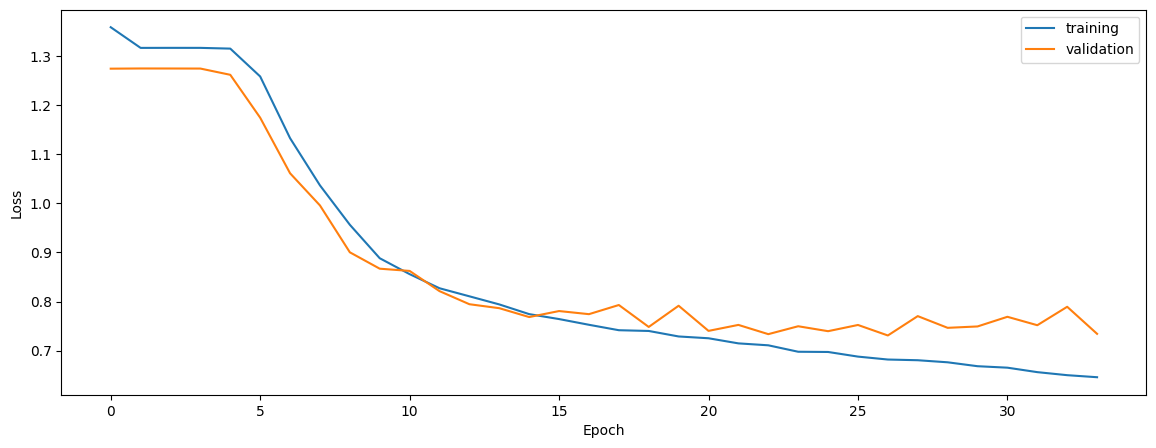

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7610099463775069
0.7462443214856146
0.7632321536881682


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7610099463775069
0.7462443214856146
0.7632321536881682


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7577122567995419
0.7566986993164546
0.7633246616764002


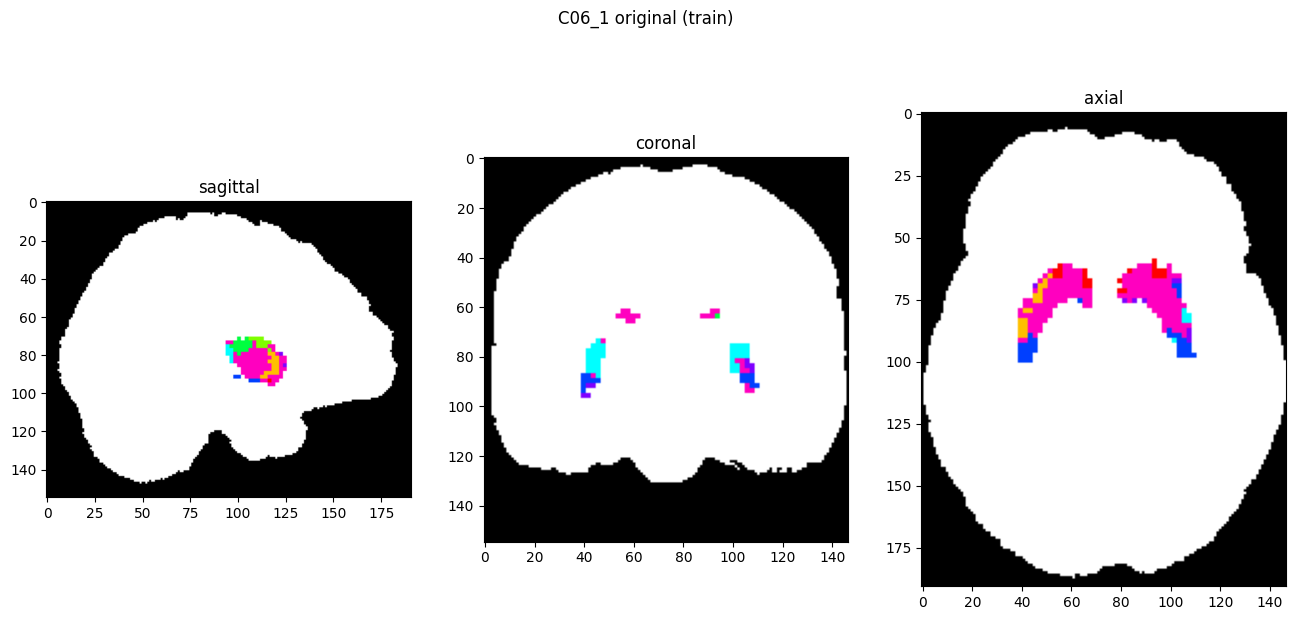

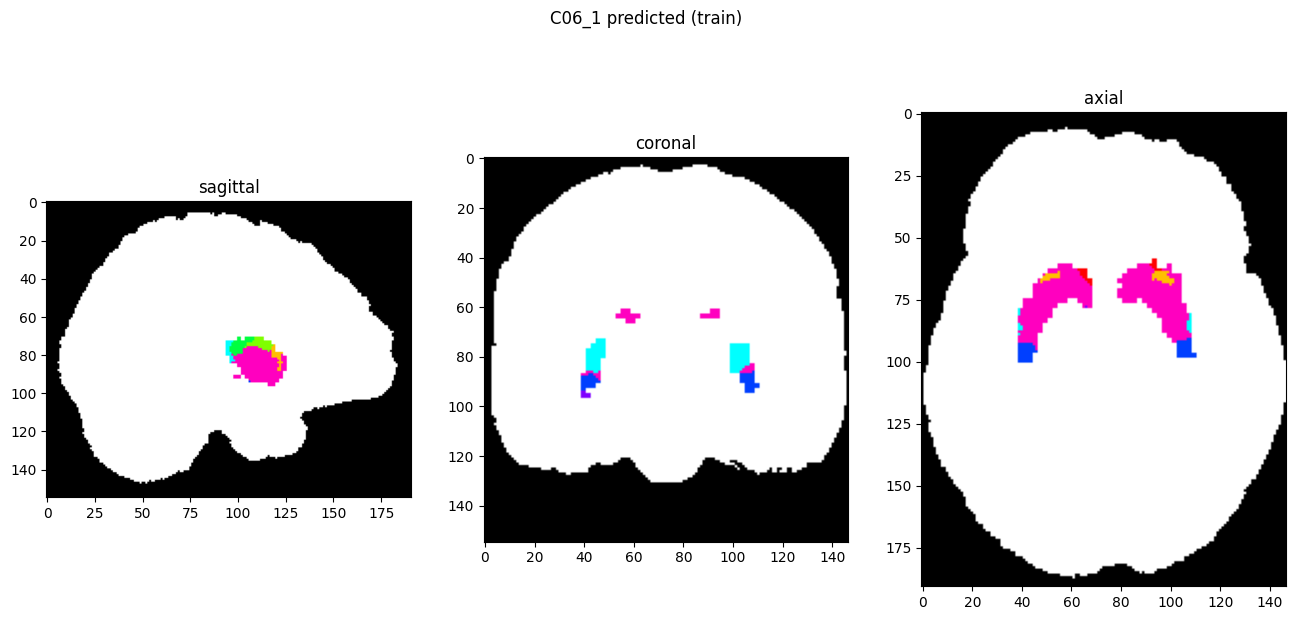

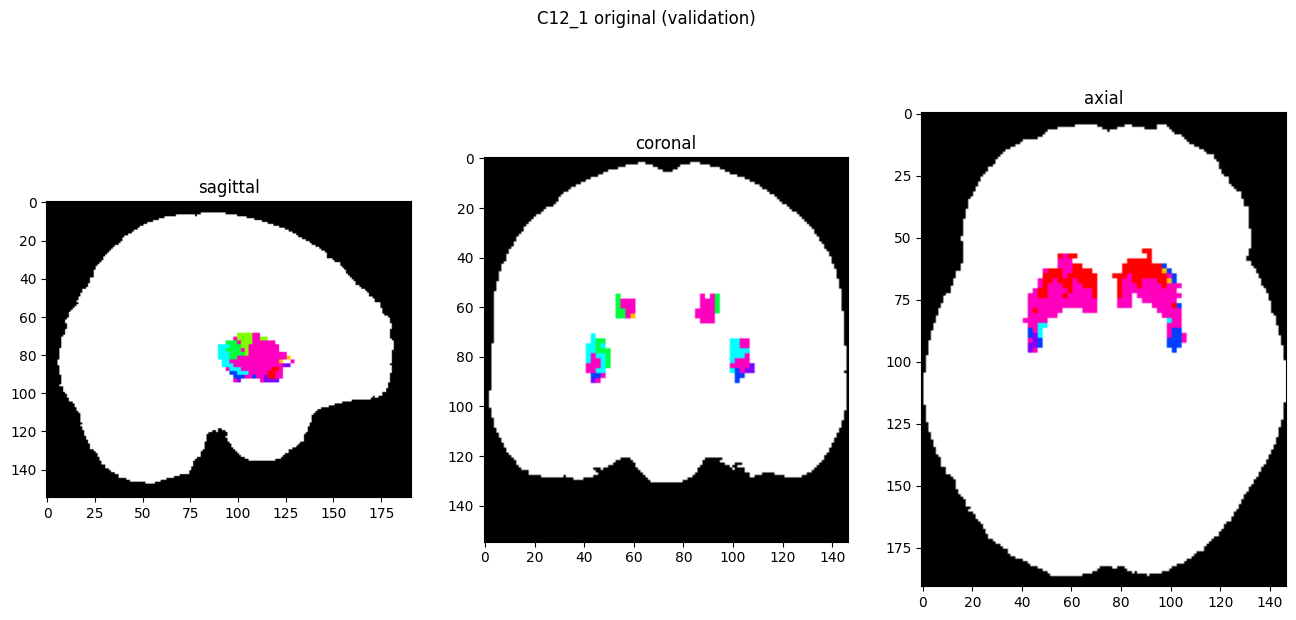

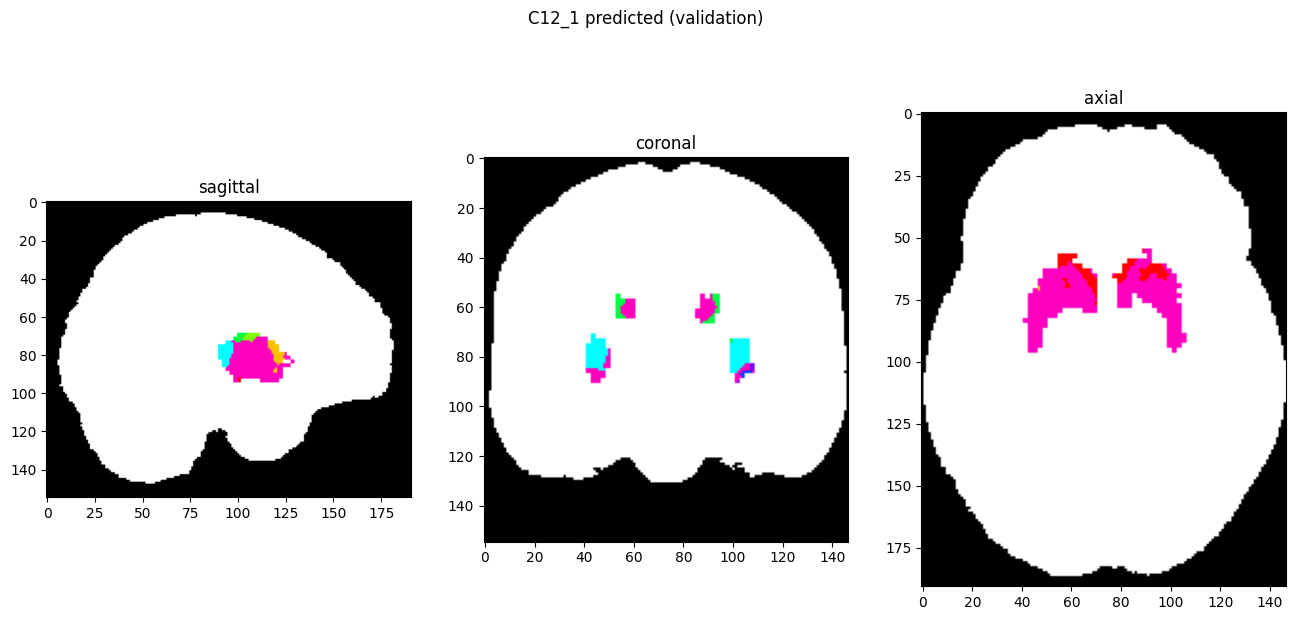

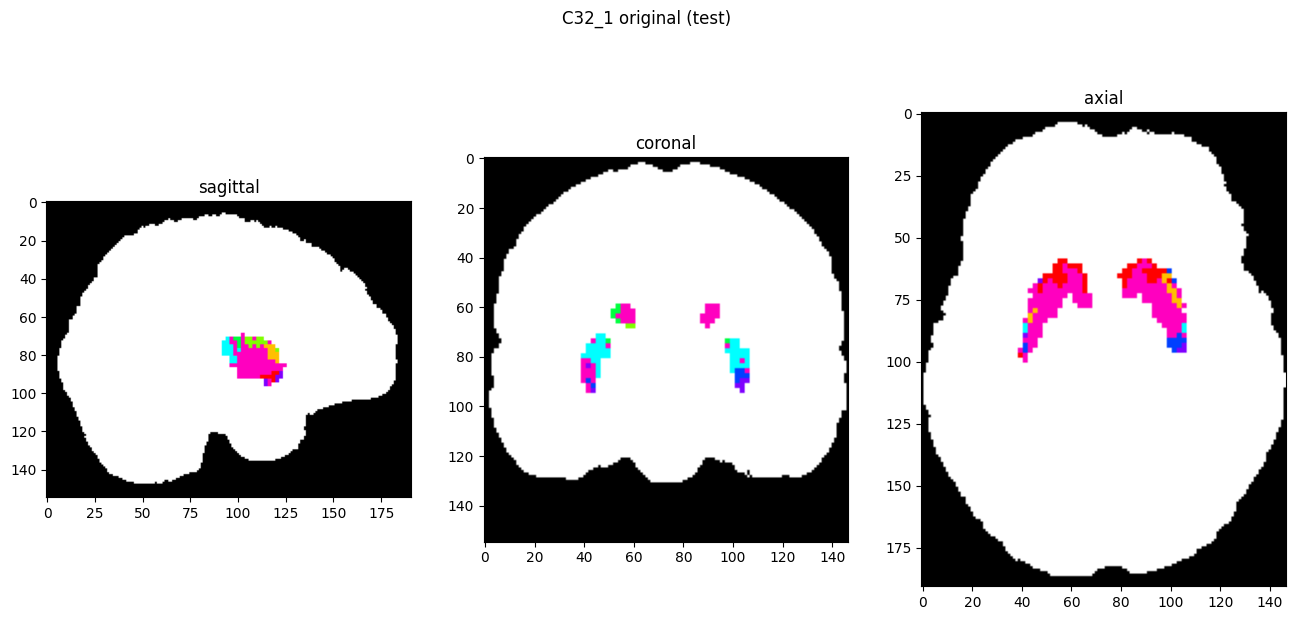

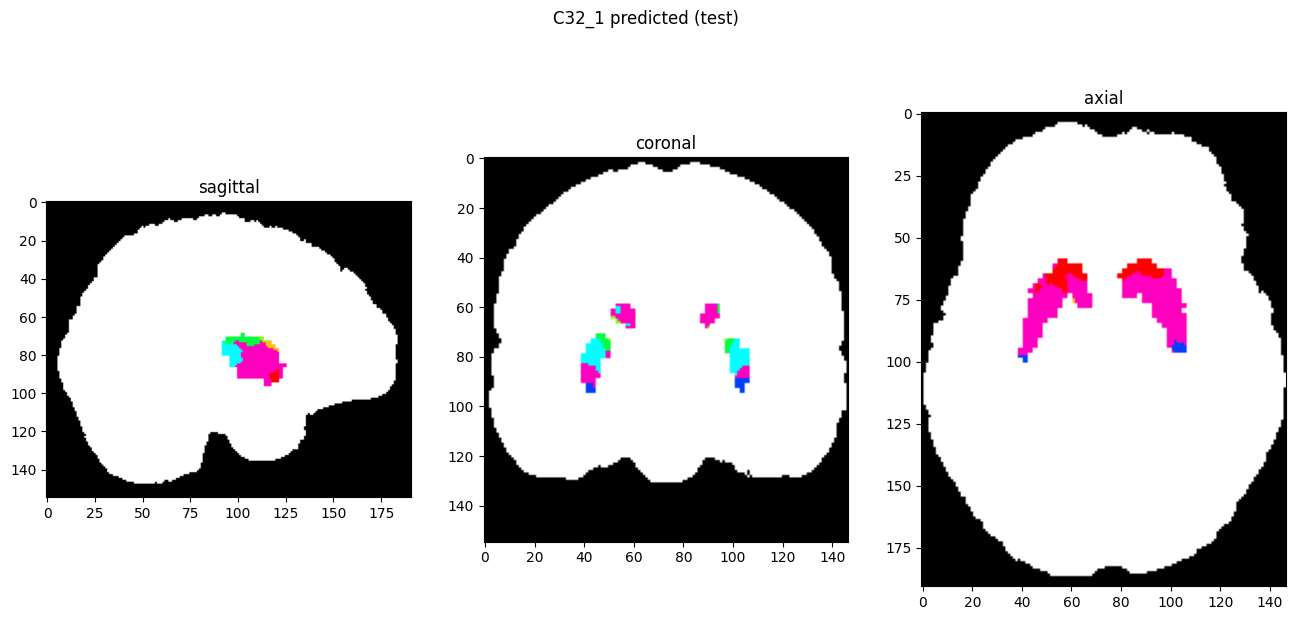

In [10]:
showResults(model, gen, threshold=0)